In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [90]:
data_paths = ['out_2024-03-25-10-31-23_one_person_moving',
              'out_2024-03-25-10-34-45_two_people_moving',
              'out_2024-03-25-10-32-56_one_standing_one_moving',
              'out_2024-03-25-10-37-34_two_in_parallel']

topics = ['/_qualisys_pedestrian_pose.csv', '/_qualisys_tinman_pose.csv',
          '/_qualisys_pedestrian_velocity.csv', '/_qualisys_tinman_velocity.csv',
          '/_objectposes.csv', '/_person_state_estimation_person_states.csv']

### Time (x-axis) vs Y coordinate (y-axis) of ground truth, objectpose, personstate_prediction

In [108]:
MARKERS = [',', 's', 'x', 'o', "<", "p"]

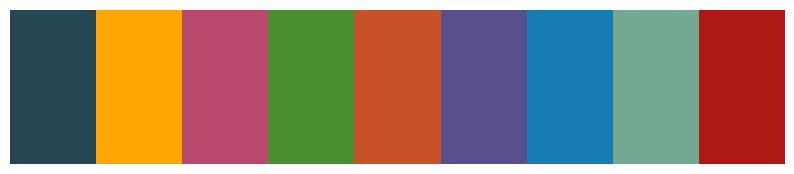

In [109]:
import matplotlib.patches as patches

COLORS = ['#264653', '#ffa600','#b8496c', '#488f31',  '#c7522a',  '#58508d', '#177cb3', '#74a892', '#ad1714']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 2))  # Figure size can be adjusted

# Remove axes
ax.axis('off')

# Plot each color as a rectangle patch and print the hex code
for i, color in enumerate(COLORS):
    # Create a rectangle patch and add it to the axes
    rect = patches.Rectangle((i, 0), 1, 1, linewidth=1, edgecolor='none', facecolor=color)
    ax.add_patch(rect)
# Set the axes limits to fit the patches
ax.set_xlim(0, len(COLORS))
ax.set_ylim(0, 1)

plt.show()

In [129]:
def read_data(file_path, topic):    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path + topic)

    # Converting stamp_secs to a readable datetime format for plotting
    # df["time"] = pd.to_datetime(df["'header.stamp.secs"], unit='s')
    df['time'] = pd.to_datetime(df['header.stamp.secs'], unit='s') + pd.to_timedelta(df['header.stamp.nsecs'], unit='ns')
    df = df.sort_values(by='time')
    if topic == '/_objectposes.csv':
        df = df[df['objects.object.label'] == 'person']

    return df

def get_topic_data(topic):
    if topic == '/_objectposes.csv':
        person_id_col = 'objects.object.id'
        topic_x = 'objects.pose.pose.position.x'
        topic_y = 'objects.pose.pose.position.y'
        topic_label = 'Objectpose'
        alpha = 0.6
    elif topic == '/_person_state_estimation_person_states.csv':
        person_id_col = 'personstate.id'
        topic_x = 'personstate.pose.position.x'
        topic_y = 'personstate.pose.position.y'
        topic_label = 'Personstate'
        alpha = 0.9
    elif topic == '/_qualisys_pedestrian_pose.csv':
        person_id_col = ''
        topic_x = 'pose.position.x'
        topic_y = 'pose.position.y'
        topic_label = 'GroundTruth Pedestrian'
        alpha = 0.5
    elif topic == '/_qualisys_tinman_pose.csv':
        person_id_col = ''
        topic_x = 'pose.position.x'
        topic_y = 'pose.position.y'
        topic_label = 'GroundTruth Tinman'
        alpha = 0.5
    return person_id_col, topic_x, topic_y, topic_label, alpha


def plot_topic_for_persons(df, person_id_col, topic, xaxis, yaxis, marker, ax, alpha=0.7):
    # Get unique person IDs
    if person_id_col in df.columns:
        unique_person_ids = df[person_id_col].dropna().unique()
        id_colors = {str(id_): COLORS[i] for i, id_ in enumerate(unique_person_ids)}
        id_colors[str(np.nan)] = 'black'
        for person_id in unique_person_ids:
            person_df = df[df[person_id_col] == person_id]
            ax.scatter(person_df[xaxis], person_df[yaxis], label=f'ID {person_id}/ {topic}', color=id_colors[str(person_id)], edgecolor='black', marker=marker, alpha=alpha, s=20)
    else:
        color = "#ad1714" if 'Pedestrian' in topic else '#560B0A'
        ax.scatter(df[xaxis], df[yaxis], label=f'{topic}', color=color, alpha=alpha, s=20, marker=marker)
   

def plot_topic_for_persons_direction(df, person_id_col, topic, xaxis, yaxis, marker, ax, alpha=0.7):
    # Define colors for NaN and a fallback color
    nan_color = 'black'
    fallback_color = "#ad1714" if 'Pedestrian' in topic else '#560B0A'
    
    # Check if person_id_col exists in the dataframe and has valid data
    if person_id_col in df.columns:
        unique_person_ids = df[person_id_col].dropna().unique()
        
        # Prepare colors for each ID, ensuring a unique color is used and assign one for NaN
        id_colors = {str(id_): COLORS[i % len(COLORS)] for i, id_ in enumerate(unique_person_ids)}
        id_colors[str(np.nan)] = nan_color
        
        for person_id in unique_person_ids:
            person_df = df[df[person_id_col] == person_id]
            
            # Extract x and y values
            x_values = person_df[xaxis].values
            y_values = person_df[yaxis].values
            
            # Plot arrows for direction
            for i in range(len(x_values)-1):
                ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
                            arrowprops=dict(arrowstyle="->", color=id_colors[str(person_id)], alpha=alpha),
                            alpha=alpha)
            
            # Also scatter plot to show the points clearly
            ax.scatter(x_values, y_values, label=f'ID {person_id} / {topic}', color=id_colors[str(person_id)], alpha=alpha, s=20, marker=marker)
    else:
        # Extract x and y values
        x_values = df[xaxis].values
        y_values = df[yaxis].values
        
        # Plot arrows for direction
        for i in range(len(x_values)-1):
            ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
                        arrowprops=dict(arrowstyle="->", color=fallback_color, alpha=alpha),
                        alpha=alpha)
        
        # Plot without person IDs
        ax.scatter(x_values, y_values, label=f'{topic}', color=fallback_color, alpha=alpha, s=20, marker=marker)


In [130]:
# _person_state_estimation_person_states.csv:  header.stamp.secs,header.stamp.nsecs, personstate.id, personstate.pose.position.y, personstate.pose.position.x, personstate.velocity,personstate.direction
# _objectposes.csv: header.stamp.secs,header.stamp.nsecs, objects.pose.pose.position.x,objects.pose.pose.position.y, objects.object.id,objects.object.label
# _qualisys_pedestrian_pose.csv: header.stamp.secs,header.stamp.nsecs, pose.position.x, pose.position.y, pose.orientation.x,pose.orientation.y
# _qualisys_pedestrian_velocity.csv: header.stamp.secs,header.stamp.nsecs, twist.linear.x, twist.linear.y

In [131]:
# _person_state_estimation_person_states.csv: header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,personstate.id,personstate.counter,personstate.pose.position.x,personstate.pose.position.y,personstate.pose.position.z,personstate.pose.orientation.x,personstate.pose.orientation.y,personstate.pose.orientation.z,personstate.pose.orientation.w,personstate.velocity,personstate.direction
# _objectposes.csv: header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,objects.pose.pose.position.x,objects.pose.pose.position.y,objects.pose.pose.position.z,objects.pose.pose.orientation.x,objects.pose.pose.orientation.y,objects.pose.pose.orientation.z,objects.pose.pose.orientation.w,objects.pose.covariance.0,objects.pose.covariance.1,objects.pose.covariance.2,objects.pose.covariance.3,objects.pose.covariance.4,objects.pose.covariance.5,objects.pose.covariance.6,objects.pose.covariance.7,objects.pose.covariance.8,objects.pose.covariance.9,objects.pose.covariance.10,objects.pose.covariance.11,objects.pose.covariance.12,objects.pose.covariance.13,objects.pose.covariance.14,objects.pose.covariance.15,objects.pose.covariance.16,objects.pose.covariance.17,objects.pose.covariance.18,objects.pose.covariance.19,objects.pose.covariance.20,objects.pose.covariance.21,objects.pose.covariance.22,objects.pose.covariance.23,objects.pose.covariance.24,objects.pose.covariance.25,objects.pose.covariance.26,objects.pose.covariance.27,objects.pose.covariance.28,objects.pose.covariance.29,objects.pose.covariance.30,objects.pose.covariance.31,objects.pose.covariance.32,objects.pose.covariance.33,objects.pose.covariance.34,objects.pose.covariance.35,objects.obstacle_width_point_1.x,objects.obstacle_width_point_1.y,objects.obstacle_width_point_1.z,objects.obstacle_width_point_2.x,objects.obstacle_width_point_2.y,objects.obstacle_width_point_2.z,objects.object.id,objects.object.label,objects.object.detection_conf,objects.object.tracking_conf,objects.object.image_width,objects.object.image_height,objects.object.roi.x_offset,objects.object.roi.y_offset,objects.object.roi.height,objects.object.roi.width,objects.object.roi.do_rectify
# _qualisys_pedestrian_pose.csv: header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,pose.position.x,pose.position.y,pose.position.z,pose.orientation.x,pose.orientation.y,pose.orientation.z,pose.orientation.w
# _qualisys_pedestrian_velocity.csv: header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,twist.linear.x,twist.linear.y,twist.linear.z,twist.angular.x,twist.angular.y,twist.angular.z


### Plots

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


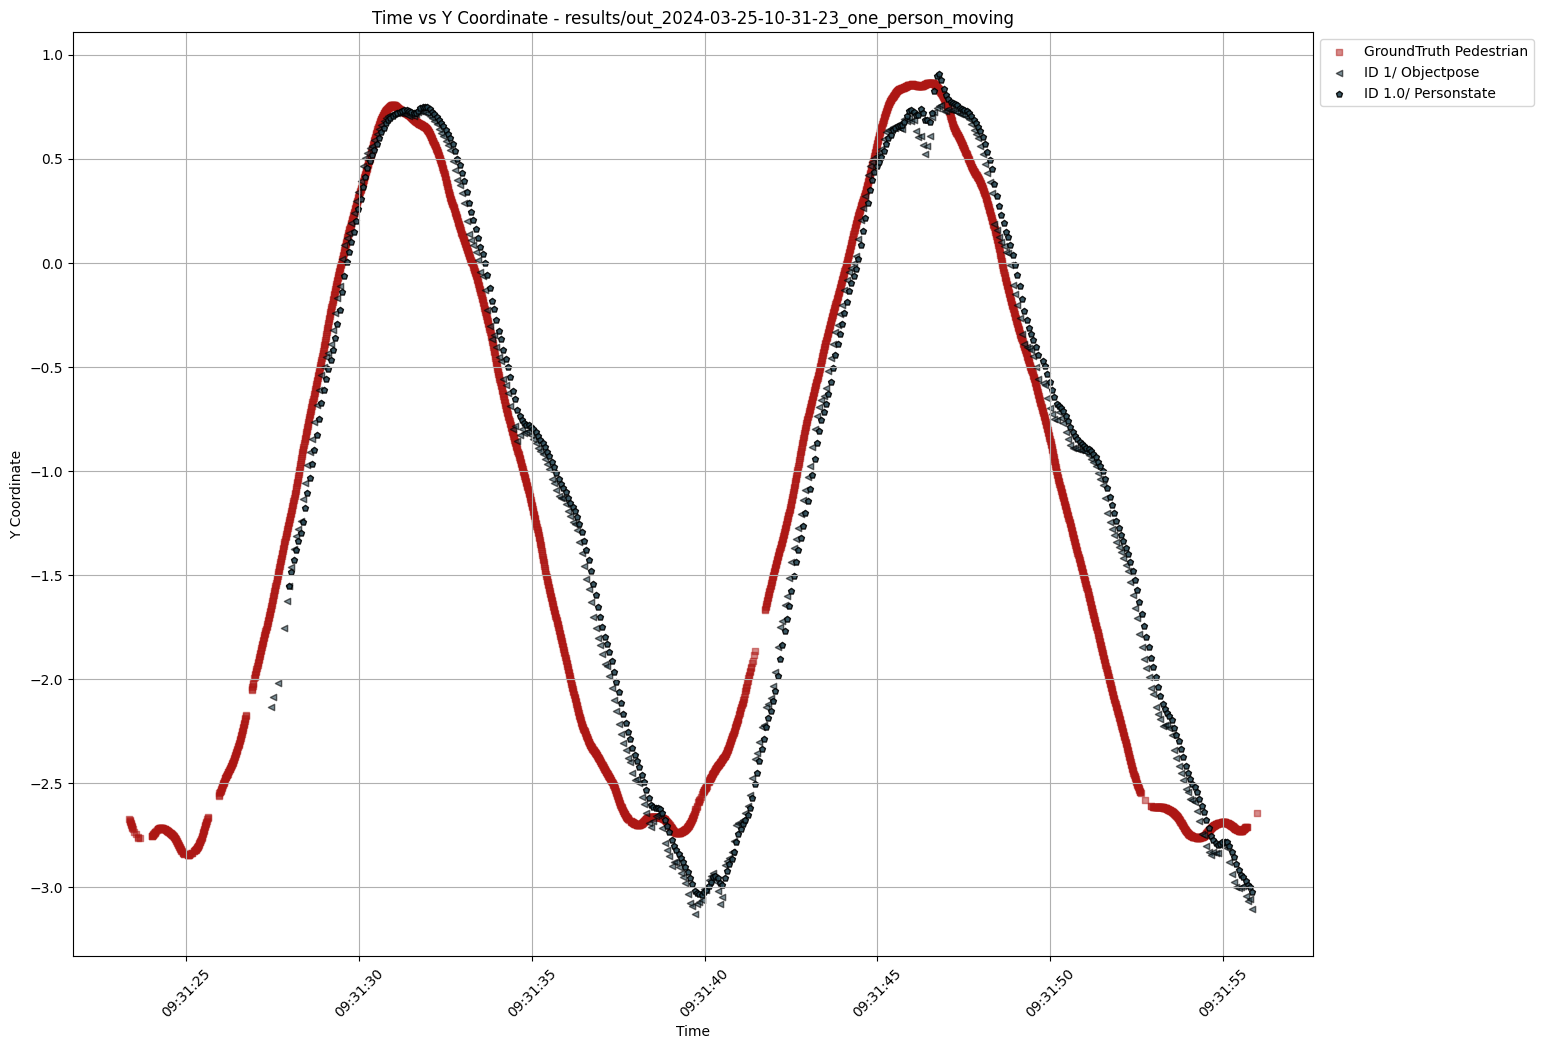

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


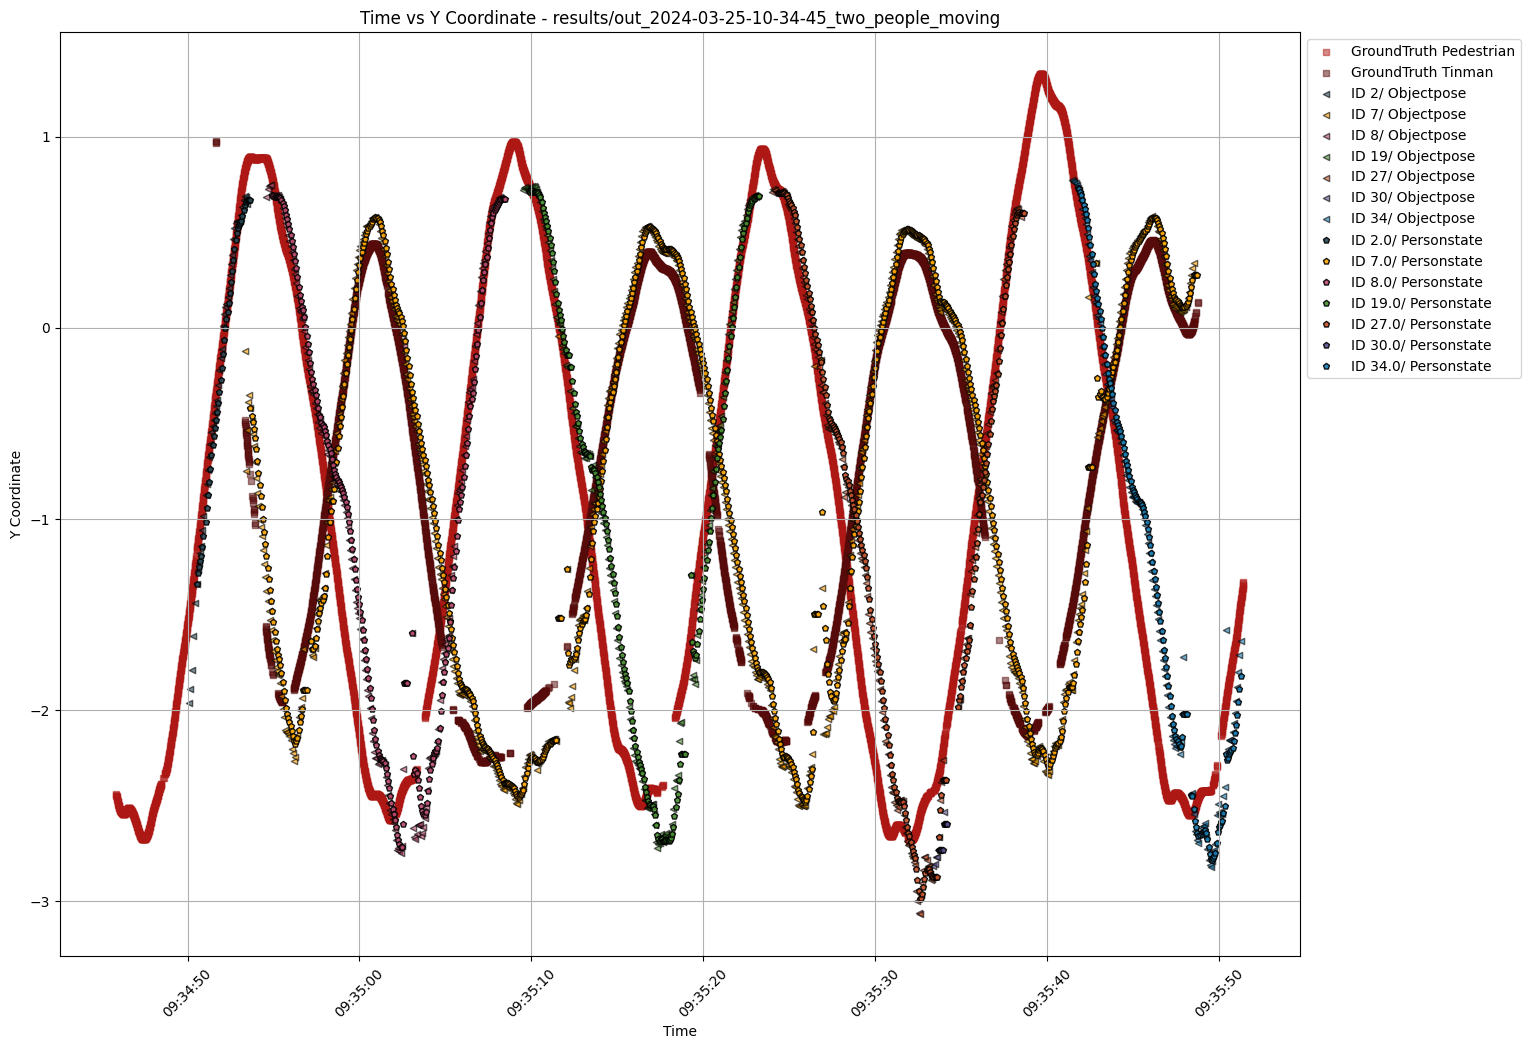

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


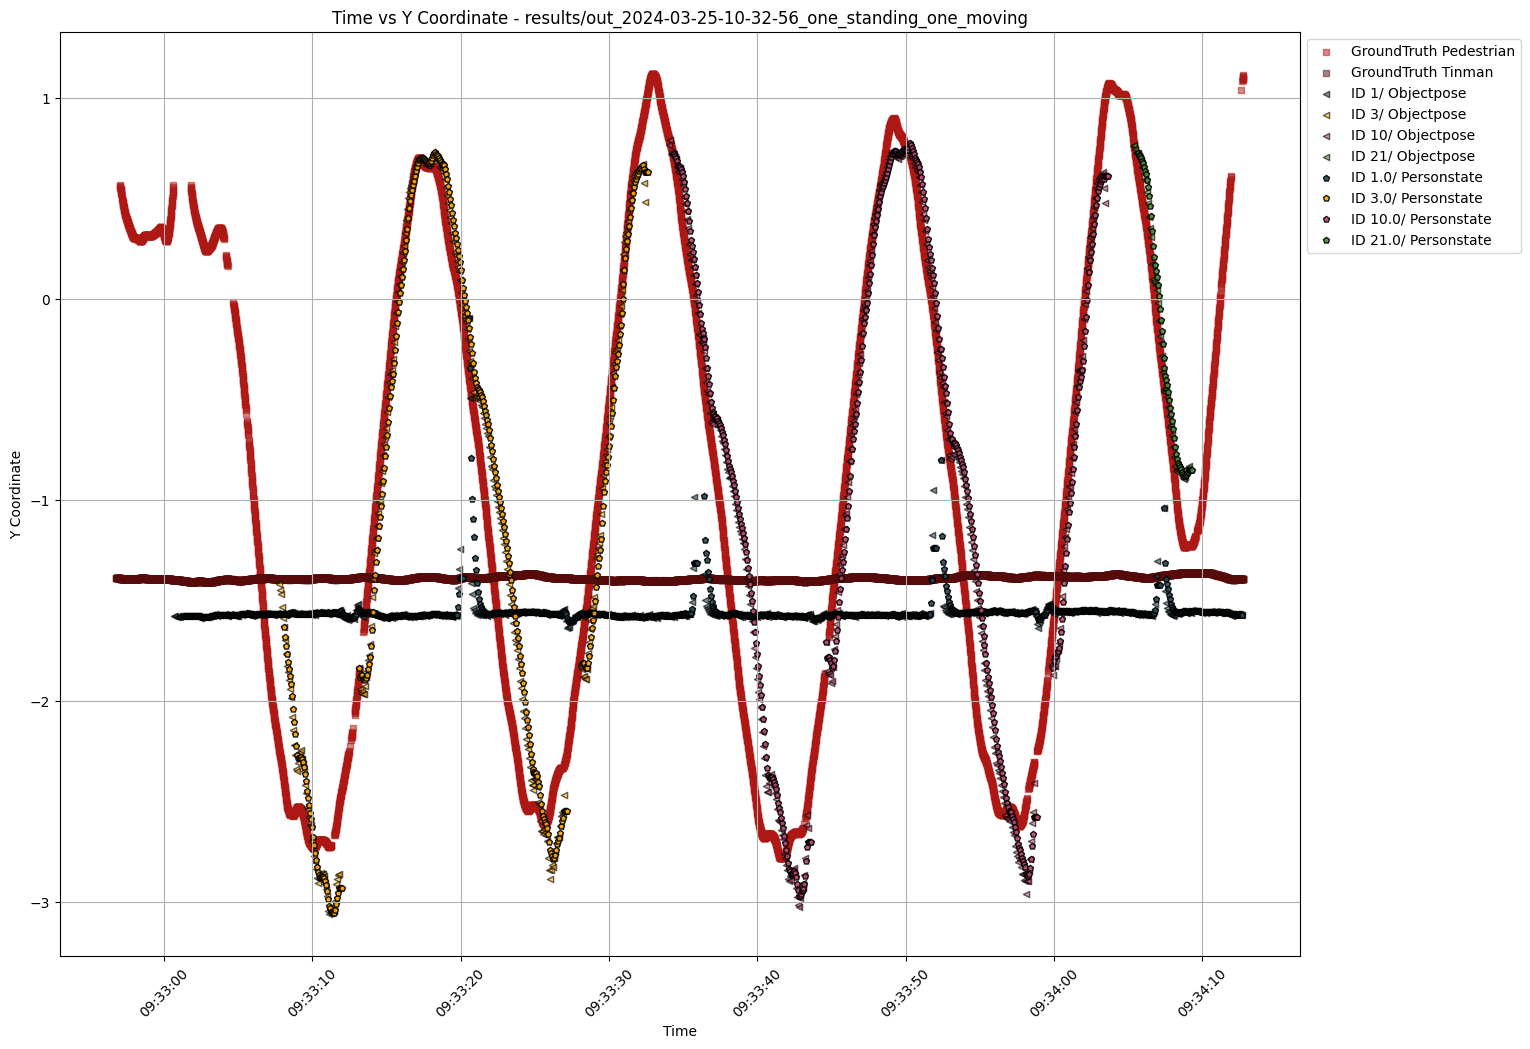

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


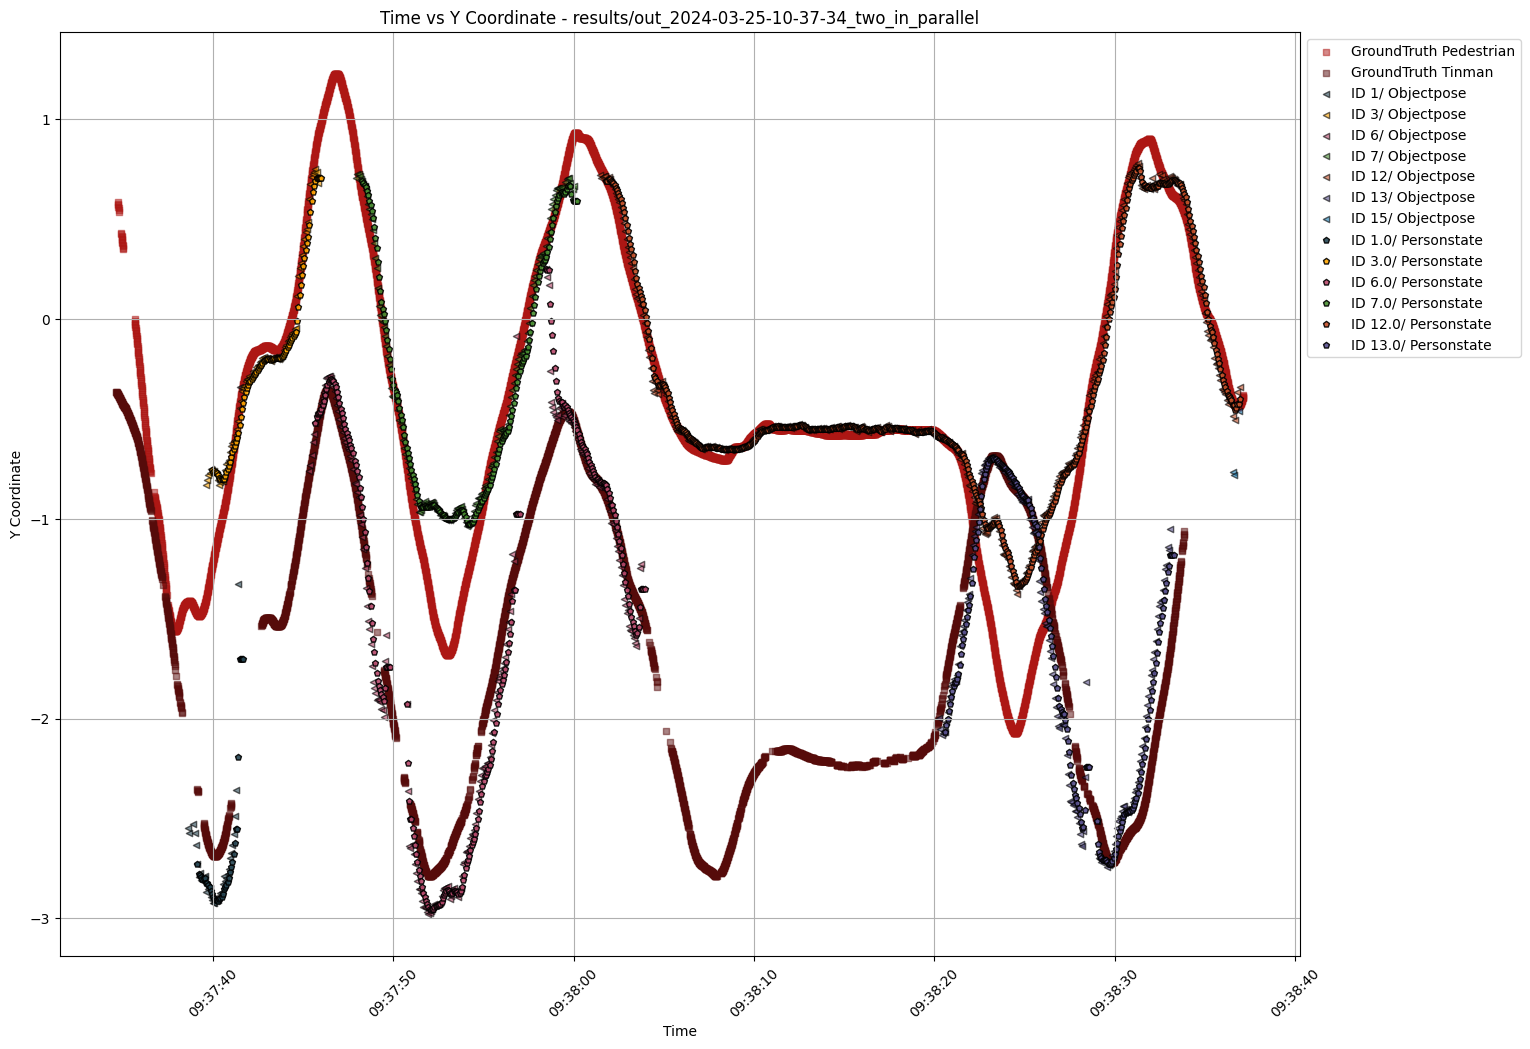

In [132]:
for file_path in data_paths:
    file_path = 'results/' + file_path
    fig, ax = plt.subplots(figsize=(16, 12))
    for i, topic in enumerate(topics):
        print('topic:', topic)
        if 'velocity' in topic or not os.path.isfile(file_path + topic): continue
        df = read_data(file_path, topic)
        person_id_col, x_coord, y_coord, topic_label, alpha = get_topic_data(topic)
        plot_topic_for_persons(df, person_id_col, topic=topic_label, xaxis='time', yaxis=y_coord, marker=MARKERS[i], ax=ax, alpha=alpha)

    ax.set_title(f"Time vs Y Coordinate - {file_path}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


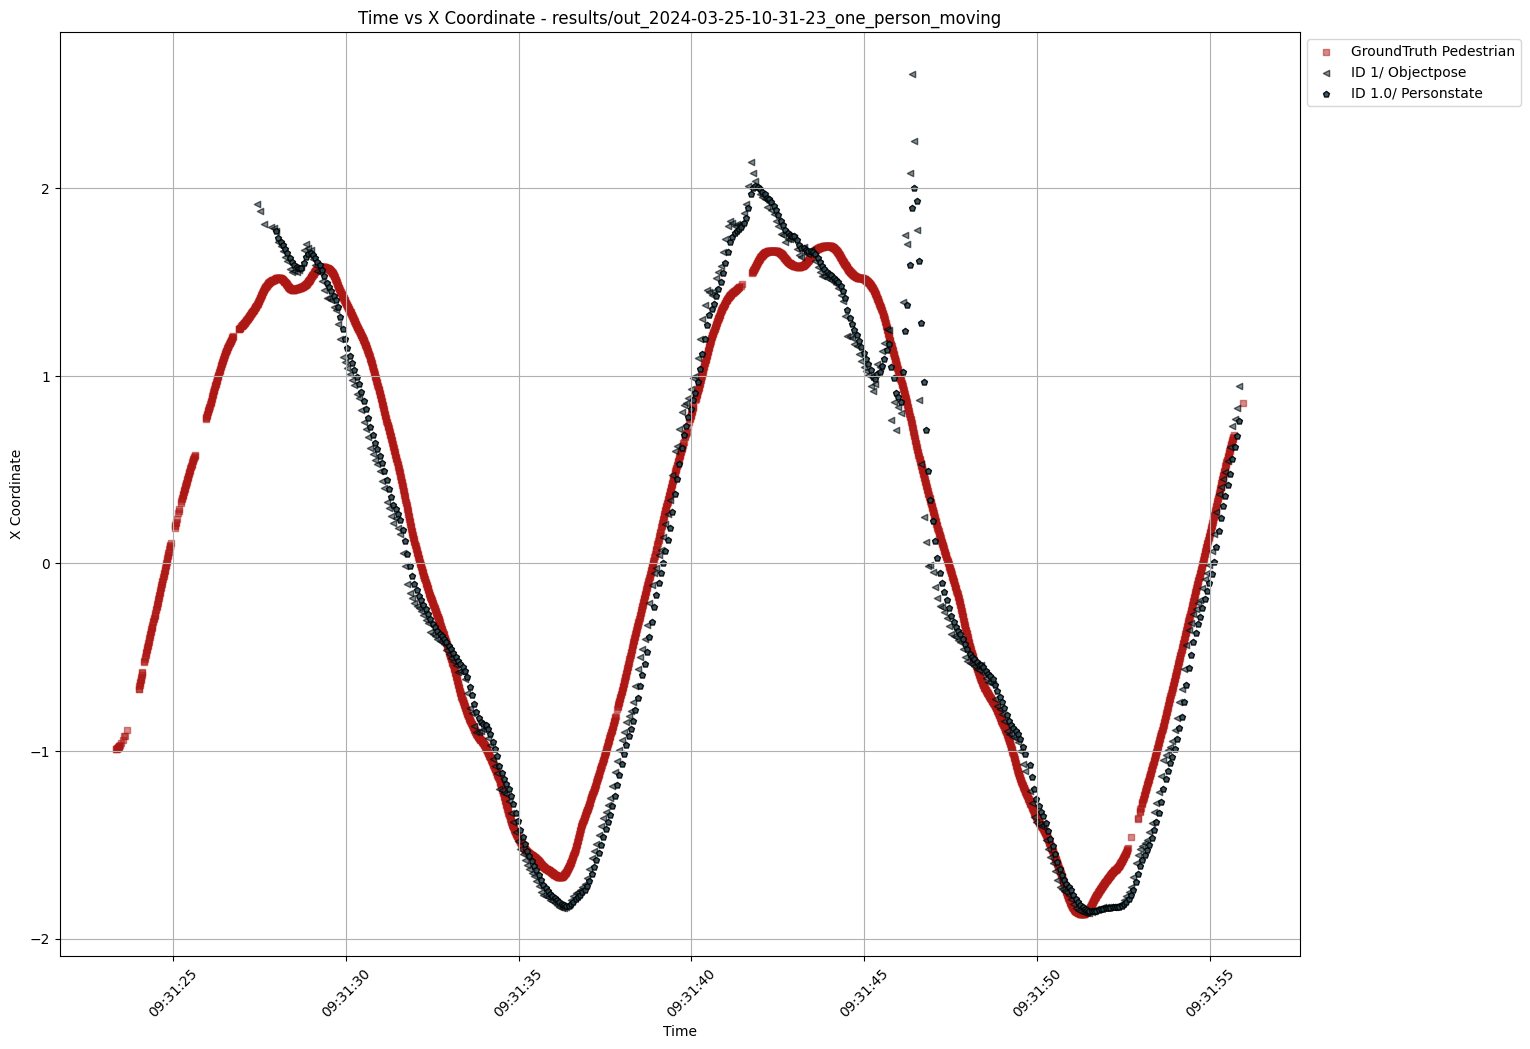

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


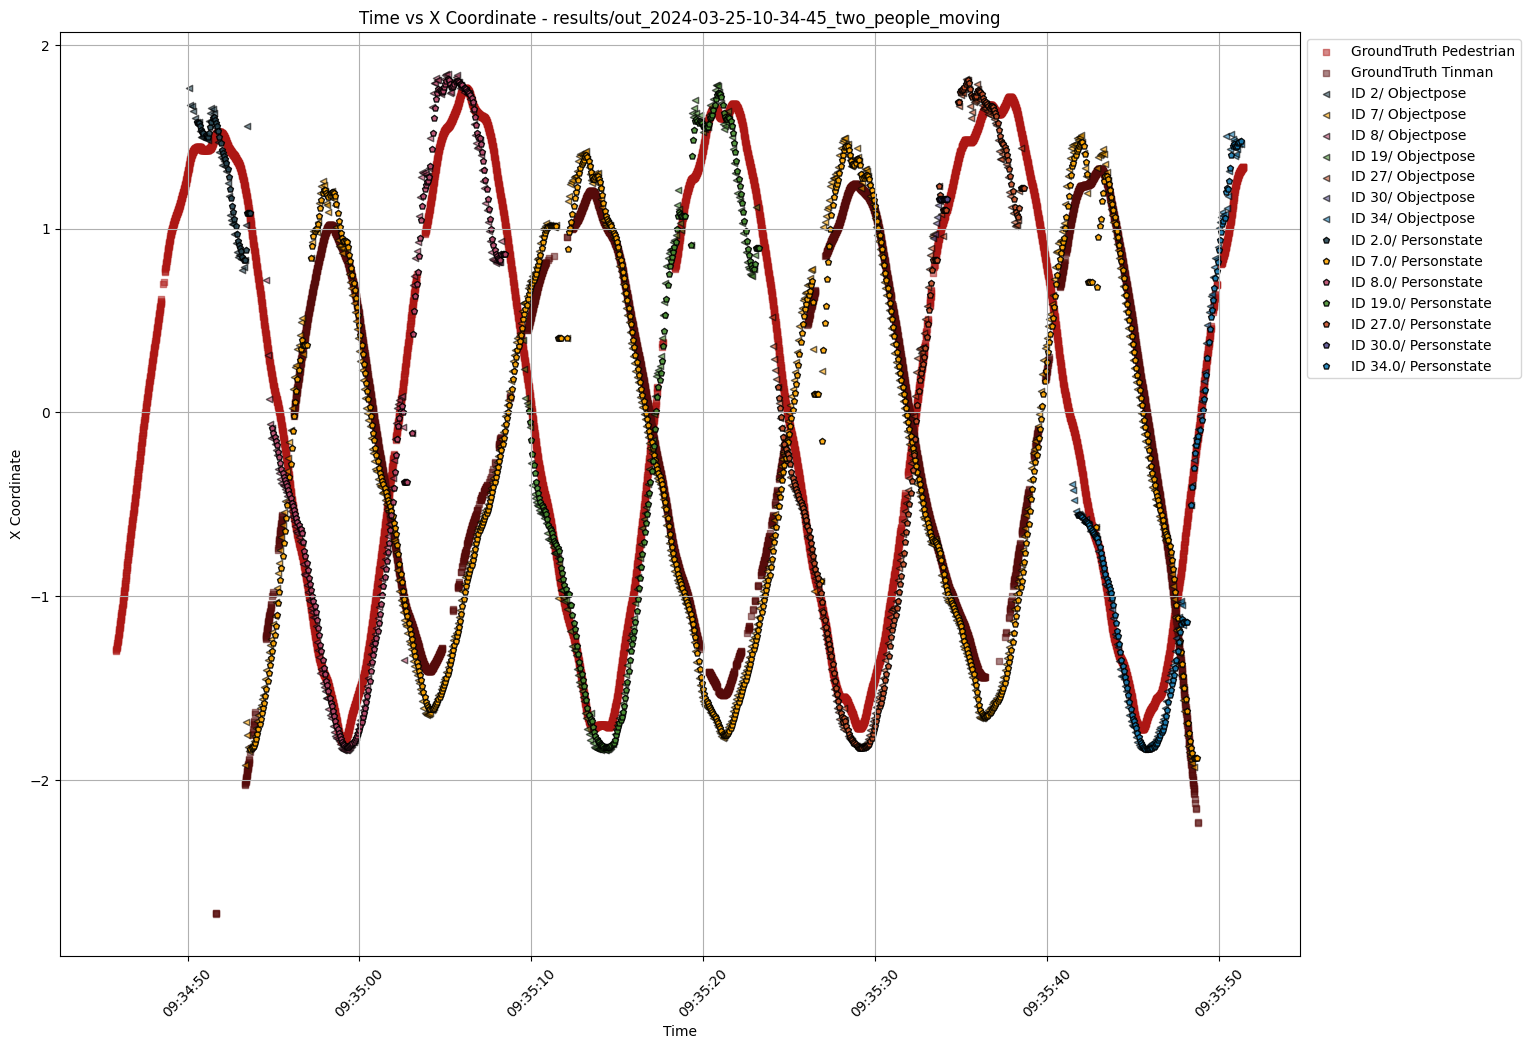

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


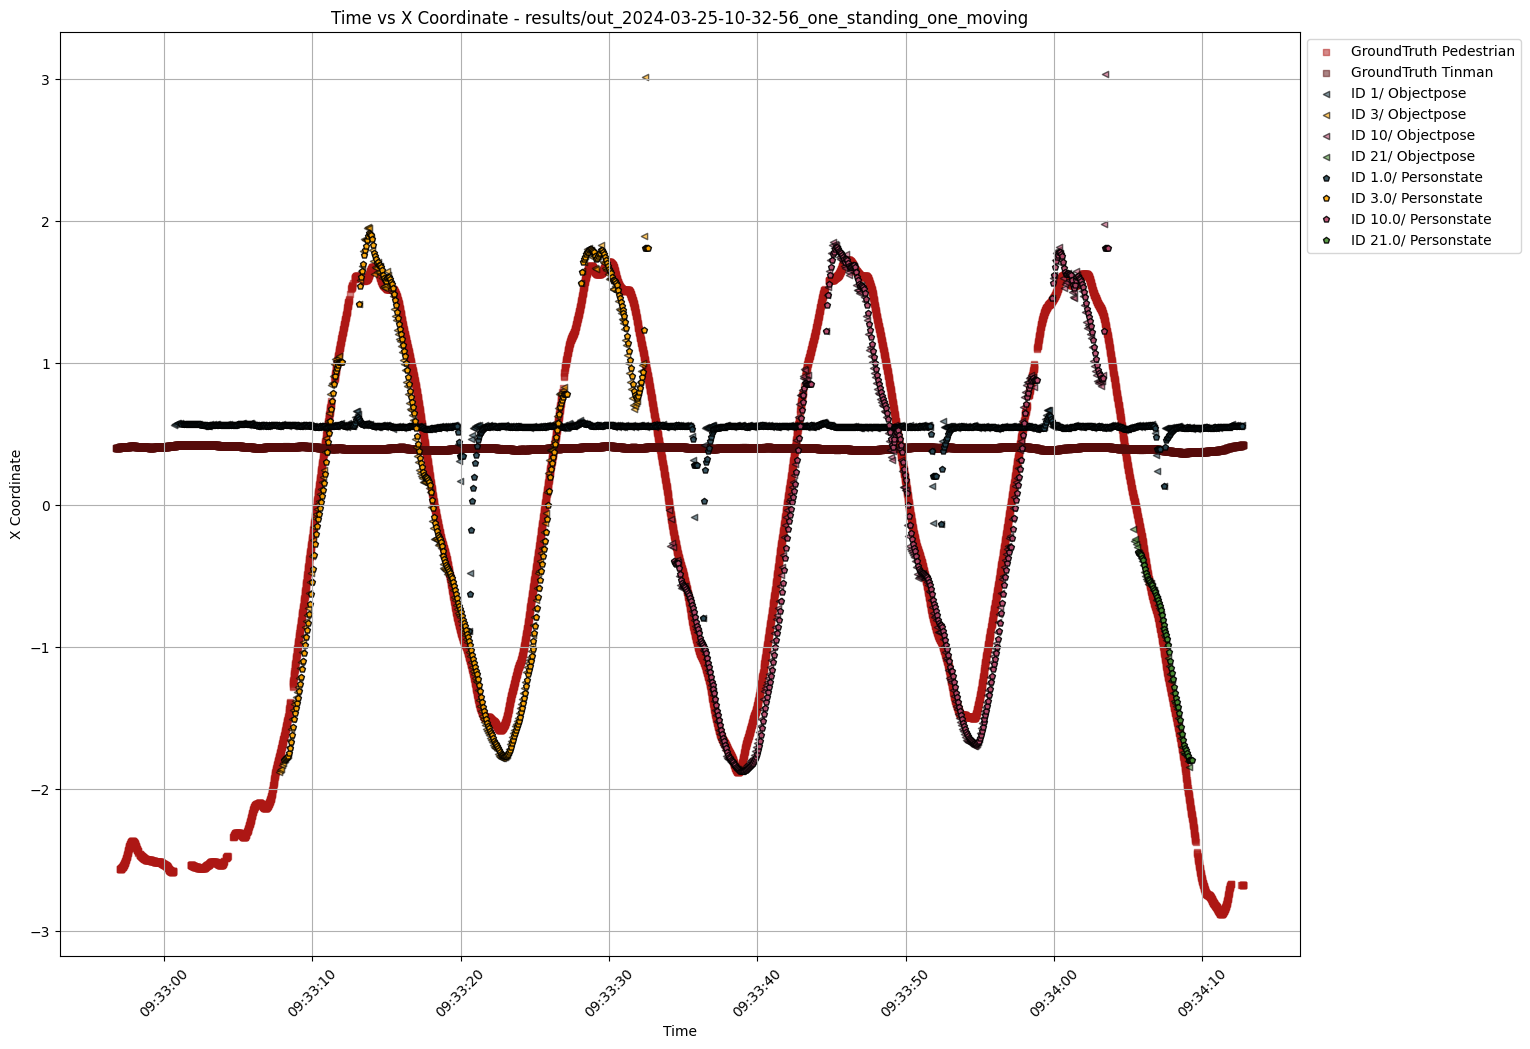

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


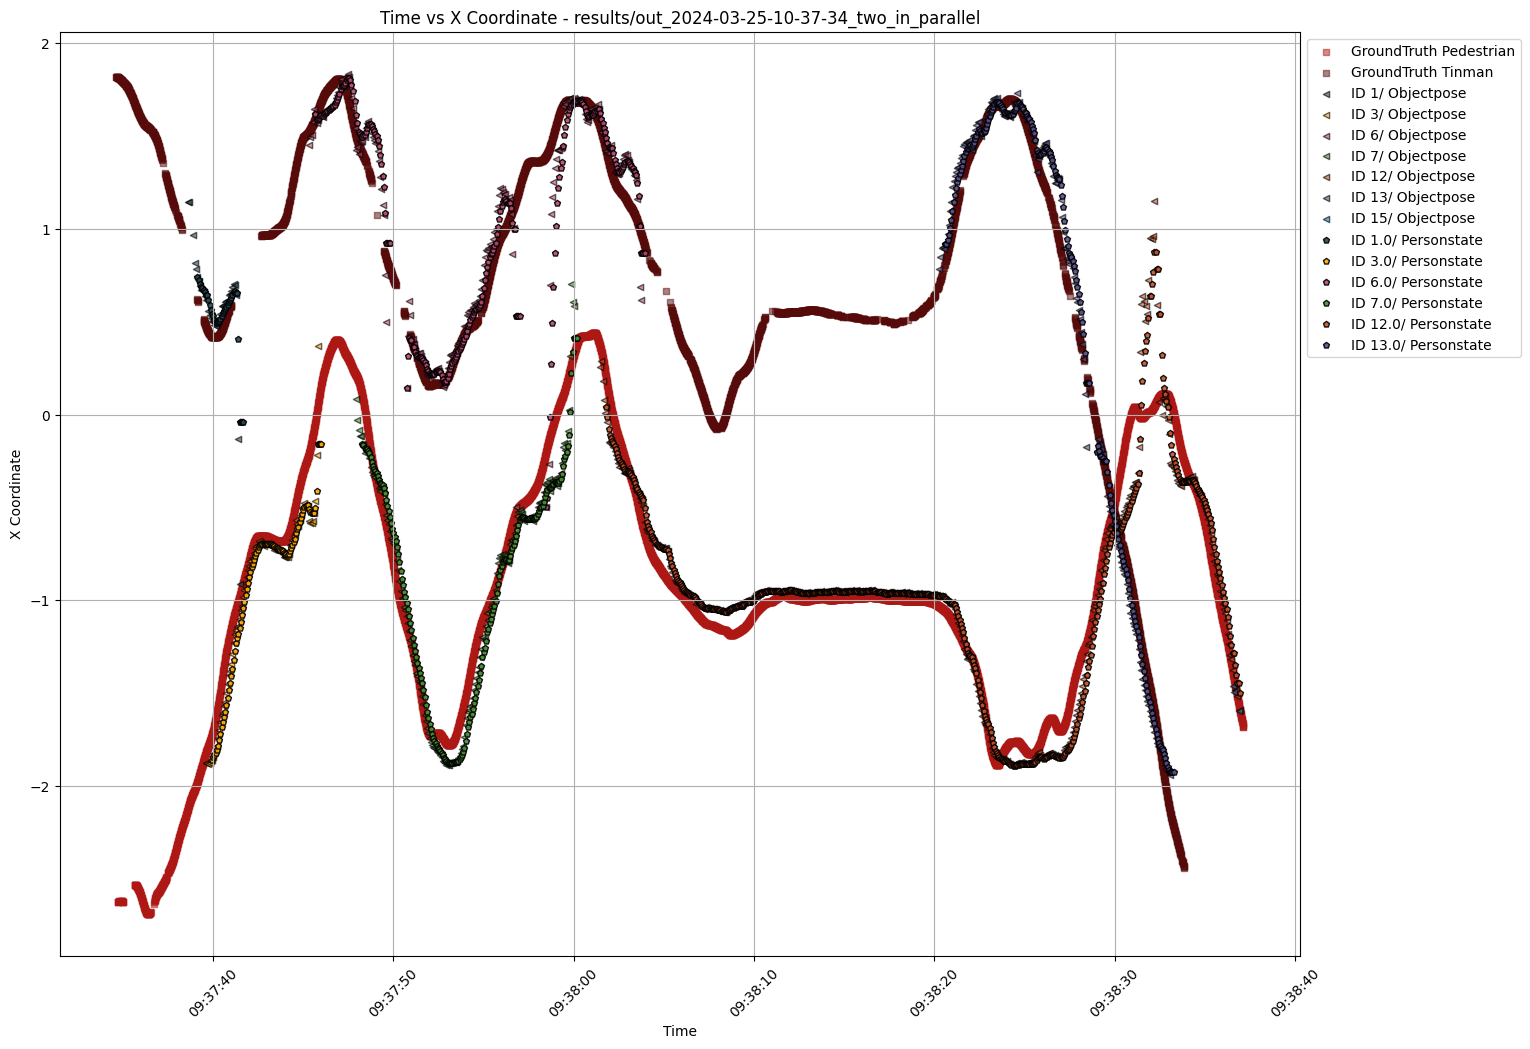

In [133]:
for file_path in data_paths:
    file_path = 'results/' + file_path
    fig, ax = plt.subplots(figsize=(16, 12))
    for i, topic in enumerate(topics):
        print('topic:', topic)
        if 'velocity' in topic or not os.path.isfile(file_path + topic): continue
        df = read_data(file_path, topic)
        person_id_col, x_coord, y_coord, topic_label, alpha = get_topic_data(topic)
        plot_topic_for_persons(df, person_id_col, topic=topic_label, xaxis='time', yaxis=x_coord, marker=MARKERS[i], ax=ax, alpha=alpha)

    ax.set_title(f"Time vs X Coordinate - {file_path}")
    ax.set_xlabel("Time")
    ax.set_ylabel("X Coordinate")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


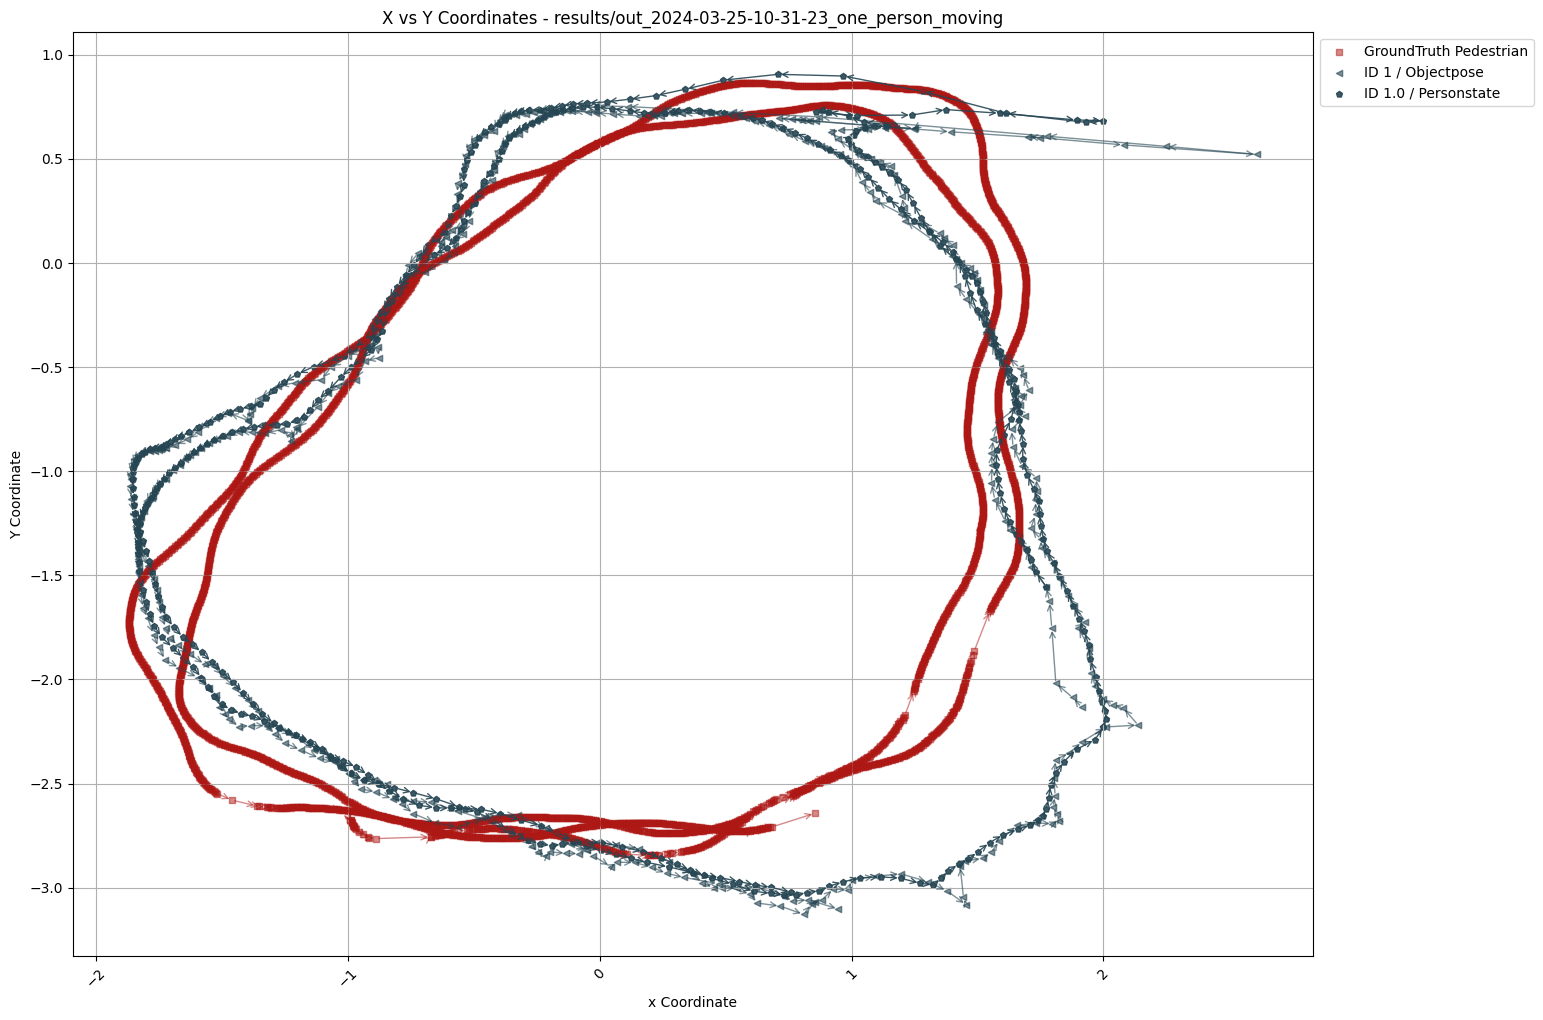

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


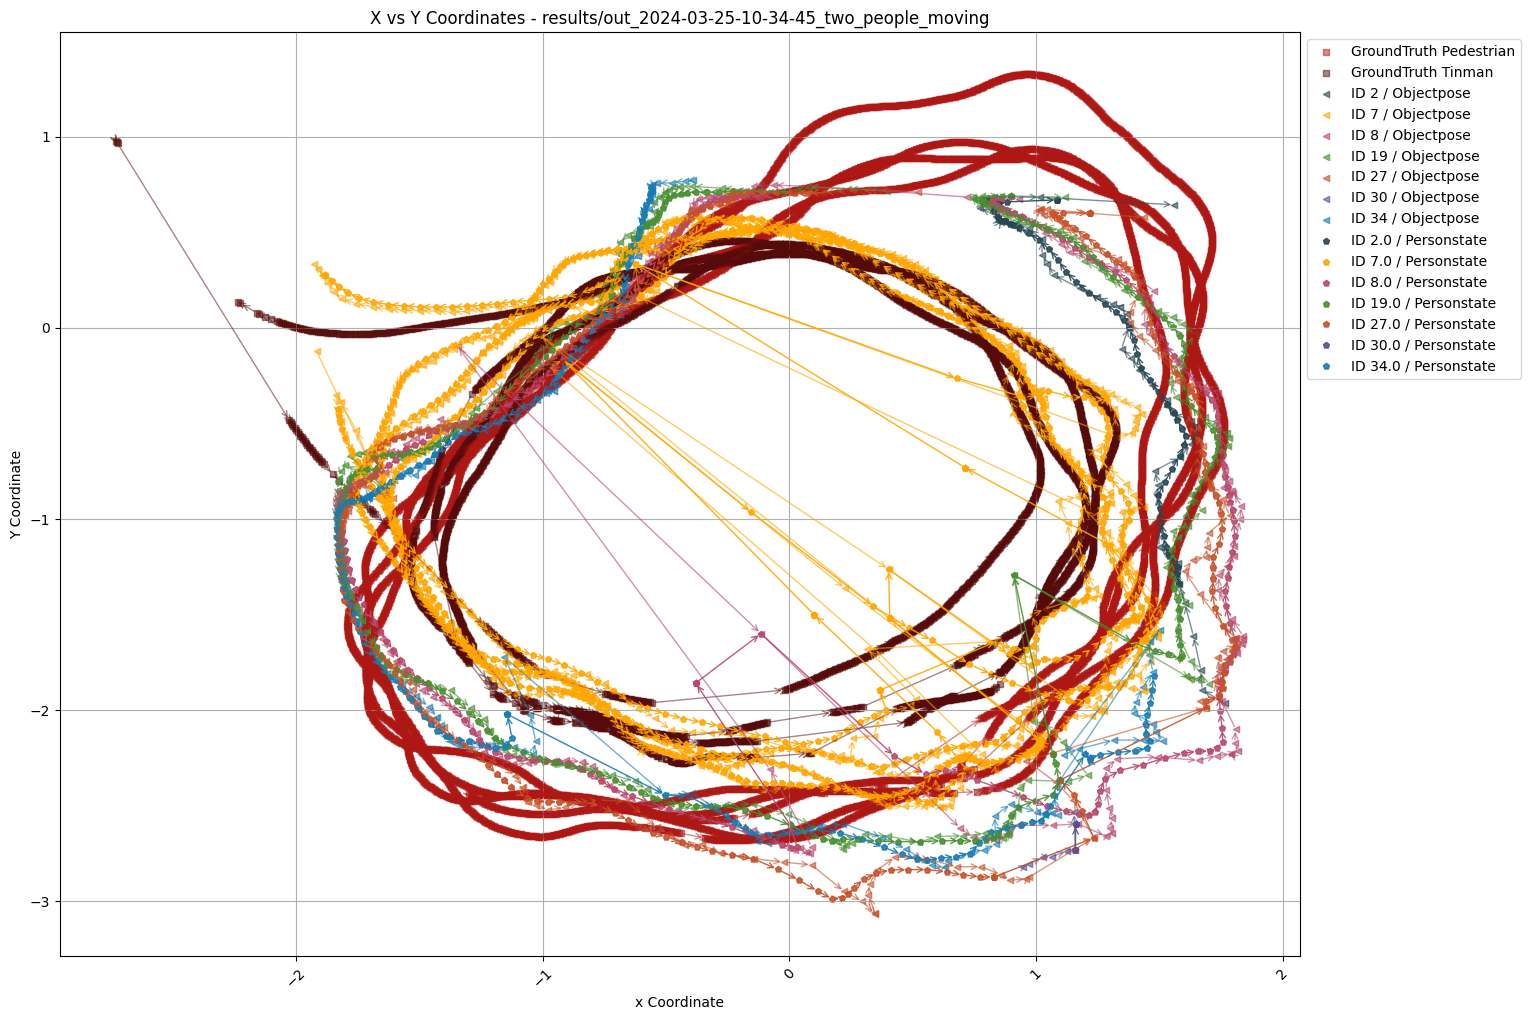

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


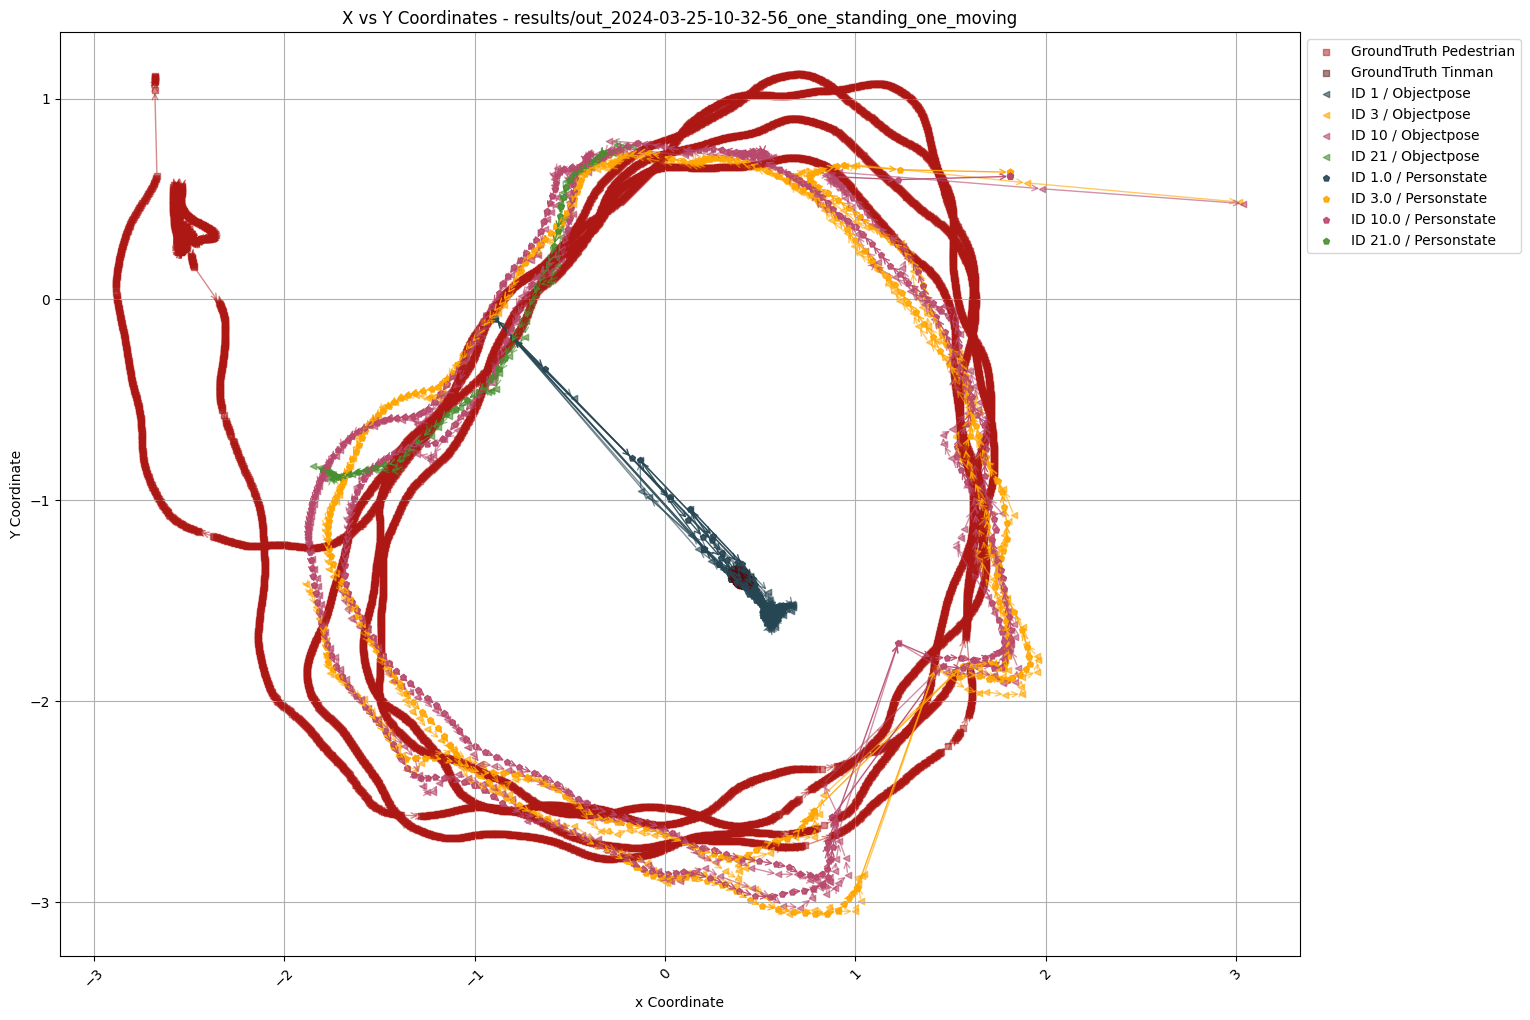

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


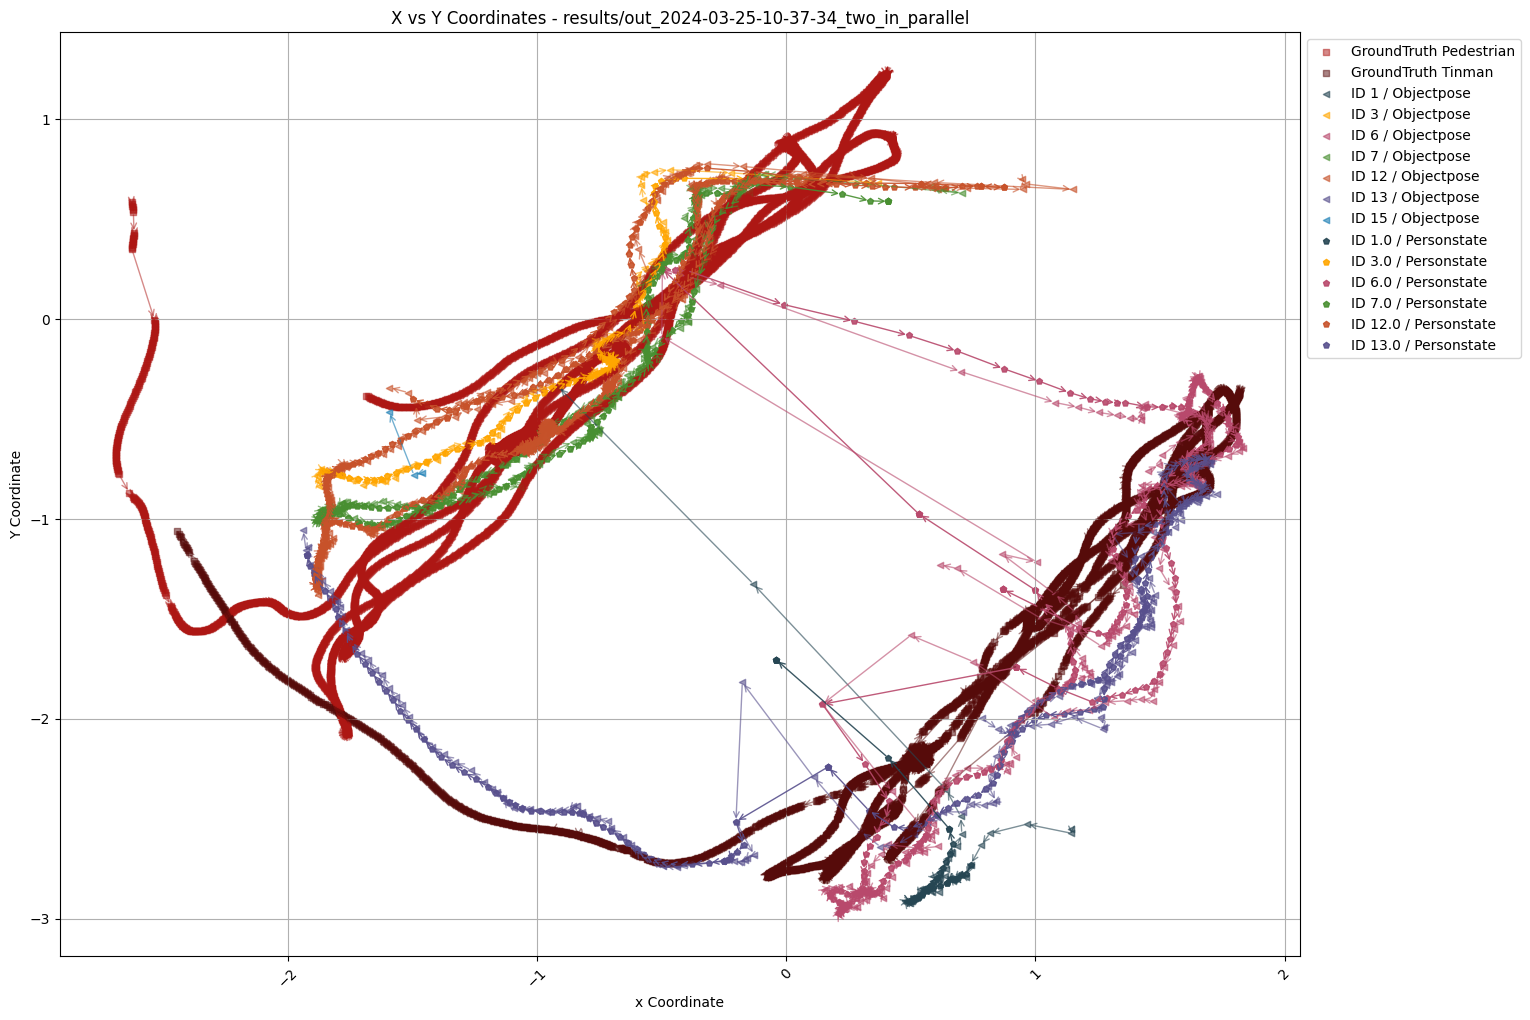

In [295]:

for file_path in data_paths:
    file_path = 'results/' + file_path
    fig, ax = plt.subplots(figsize=(16, 12))
    for i, topic in enumerate(topics):
        print('topic:', topic)
        if 'velocity' in topic or not os.path.isfile(file_path+topic): continue
        df = read_data(file_path, topic)
        person_id_col, x_coord, y_coord, topic_label, alpha = get_topic_data(topic)
        plot_topic_for_persons_direction(df, person_id_col, topic=topic_label, xaxis=x_coord, yaxis=y_coord, marker=MARKERS[i], ax=ax, alpha=alpha)

    ax.set_title(f"X vs Y Coordinates - {file_path}")
    ax.set_xlabel("x Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()

### Error

In [171]:
from sklearn.metrics import mean_squared_error

In [254]:
def find_closest_times(target_times, reference_times):
    # Find the index of the closest reference time for each target time
    indices = np.searchsorted(reference_times, target_times)
    indices = np.clip(indices, 1, len(reference_times) - 1)
    left = reference_times[indices - 1]
    right = reference_times[indices]
    indices -= target_times - left < right - target_times
    return indices

In [255]:
def calculate_distances(est_positions, gt_positions, closest_indices):
    """
    Calculate the distances from each estimated position to the ground truth position.
    """
    distances = np.sqrt((est_positions['x_values'] - gt_positions['x_values'][closest_indices])**2 + 
                        (est_positions['y_values'] - gt_positions['y_values'][closest_indices])**2)
    return distances

In [286]:
def classify_ids(estimated_positions, ground_truth_pedestrian, ground_truth_tinman):
    pedestrian_ids = []
    tinman_ids = []

    if len(ground_truth_tinman['time']) == 0 or len(ground_truth_pedestrian['time']) == 0: 
        label = 'pedestrian' if len(ground_truth_tinman['time']) == 0 else 'tinman'
        # If one ground truth is empty, assign all IDs to the other entity
        pedestrian_ids = list(estimated_positions.keys()) if label == 'pedestrian' else []
        tinman_ids = list(estimated_positions.keys()) if label == 'tinman' else []
        return pedestrian_ids, tinman_ids

    for id, est_data in estimated_positions.items():
        # Find closest indices in ground truth times for pedestrian and tinman
        closest_indices_pedestrian = find_closest_times(est_data['time'], ground_truth_pedestrian['time'])
        closest_indices_tinman = find_closest_times(est_data['time'], ground_truth_tinman['time'])

        # Calculate distances
        pedestrian_distances = calculate_distances(est_data, ground_truth_pedestrian, closest_indices_pedestrian)
        tinman_distances = calculate_distances(est_data, ground_truth_tinman, closest_indices_tinman)

        # Determine predominant classification
        pedestrian_count = sum(ped_dist < tin_dist for ped_dist, tin_dist in zip(pedestrian_distances, tinman_distances))
        tinman_count = len(pedestrian_distances) - pedestrian_count  # Remaining counts are for tinman

        # Classify ID based on majority
        if pedestrian_count > tinman_count:
            pedestrian_ids.append(id)
        else:
            tinman_ids.append(id)

    return [pedestrian_ids, tinman_ids]

In [287]:
def get_data_perperson(df, person_id_col, x_coord, y_coord):
    data_perperson = {}
    unique_person_ids = df[person_id_col].dropna().unique()
    
    for person_id in unique_person_ids:
        person_df = df[df[person_id_col] == person_id]
        
        # Extract x and y values
        x_values = person_df[x_coord].values
        y_values = person_df[y_coord].values

        data_perperson[person_id] = {"x_values": x_values, "y_values": y_values, "time": person_df['time'].values}

    return data_perperson
        

In [288]:
def combine_selected_ids(estimated_positions, ids_to_combine):
    combined_data = {'x_values': [], 'y_values': [], 'time': []}

    # Iterate over each ID and concatenate the data
    for id in ids_to_combine:
        if id in estimated_positions:
            for key in combined_data.keys():
                combined_data[key].append(estimated_positions[id][key])
    
    # Convert lists to NumPy arrays and concatenate data along the first axis
    for key in combined_data.keys():
        combined_data[key] = np.concatenate(combined_data[key])
    
    return combined_data

In [289]:
data = {}
for file_path in data_paths:
    data[file_path] = {}
    path = 'results/' + file_path
    for i, topic in enumerate(topics):
        if not os.path.isfile(path + topic): 
            data[file_path]['true_tinman'] = {"x_values": [], "y_values": [], "time": []}
            continue
        df = read_data(path, topic)
        if topic == '/_objectposes.csv':
            data_objectpose = get_data_perperson(df, 'objects.object.id', 'objects.pose.pose.position.x', 'objects.pose.pose.position.y')
            data[file_path]['objectpose'] = data_objectpose
        elif topic == '/_person_state_estimation_person_states.csv':
            data_personstate = get_data_perperson(df, 'personstate.id', 'personstate.pose.position.x', 'personstate.pose.position.y')
            data[file_path]['personstate'] = data_personstate
        elif topic == '/_qualisys_pedestrian_pose.csv':
            data[file_path]['true_pedestrian'] = {"x_values": df['pose.position.x'].values, "y_values":  df['pose.position.y'].values, "time": df['time'].values}
        elif topic == '/_qualisys_tinman_pose.csv':
            data[file_path]['true_tinman'] = {"x_values": df['pose.position.x'].values, "y_values":  df['pose.position.y'].values, "time": df['time'].values}
        else: 
            continue

data.keys()

dict_keys(['out_2024-03-25-10-31-23_one_person_moving', 'out_2024-03-25-10-34-45_two_people_moving', 'out_2024-03-25-10-32-56_one_standing_one_moving', 'out_2024-03-25-10-37-34_two_in_parallel'])

In [290]:
for key, df in data.items():
    pedestrian_ids, tinman_ids = classify_ids(df['personstate'],  df['true_pedestrian'], df['true_tinman'])
    print(key, pedestrian_ids, tinman_ids)

out_2024-03-25-10-31-23_one_person_moving [1.0] []
out_2024-03-25-10-34-45_two_people_moving [2.0, 8.0, 19.0, 27.0, 30.0, 34.0] [7.0]
out_2024-03-25-10-32-56_one_standing_one_moving [3.0, 10.0, 21.0] [1.0]
out_2024-03-25-10-37-34_two_in_parallel [3.0, 7.0, 12.0] [1.0, 6.0, 13.0]


In [301]:
clasiffied_ids_all = {}

In [302]:
for id, label in enumerate(['pedestrian', 'tinman']):
    error_values_personsate, error_values_objectpose = [], []
    print(label)
    for key, df in data.items():
        clasiffied_ids = classify_ids(df['personstate'],  df['true_pedestrian'], df[f'true_tinman'])
        clasiffied_ids_all[key] = clasiffied_ids
        if len(clasiffied_ids[id]) == 0: continue

        combined_data_personstate = combine_selected_ids(df['personstate'], clasiffied_ids[id])
        combined_data_objectpose = combine_selected_ids(df['objectpose'], clasiffied_ids[id])
            
        closest_indices_personstate = find_closest_times(combined_data_personstate['time'], df[f'true_{label}']['time'])
        closest_indices_objectpose = find_closest_times(combined_data_objectpose['time'], df[f'true_{label}']['time'])

        true_positions_x_persostate = df[f'true_{label}']['x_values'][closest_indices_personstate]
        true_positions_x_objectpose = df[f'true_{label}']['x_values'][closest_indices_objectpose]

        est_positions_x = combined_data_personstate['x_values']
        est_camera_positions_x = combined_data_objectpose['x_values']

        error_x_pesronstate = mean_squared_error(est_positions_x, true_positions_x_persostate)
        error_x_objectpose = mean_squared_error(est_camera_positions_x, true_positions_x_objectpose)
        error_values_personsate.append(error_x_pesronstate)
        error_values_objectpose.append(error_x_objectpose)
        print(f"Mean_squared_error for Position X, Personstate vs ObjectPose: {error_x_pesronstate}% vs {error_x_objectpose}%")

    average_error = sum(error_values_personsate) / len(error_values_personsate)
    average_error_obj = sum(error_values_objectpose) / len(error_values_objectpose)
    print(f"Average MSE for Position X, Personstate vs ObjectPose: {average_error} vs {average_error_obj}\n")             

pedestrian
Mean_squared_error for Position X, Personstate vs ObjectPose: 0.06815617706614073% vs 0.07808829930019588%
Mean_squared_error for Position X, Personstate vs ObjectPose: 0.04376578140664779% vs 0.05343335071746239%
Mean_squared_error for Position X, Personstate vs ObjectPose: 0.051091803458169306% vs 0.05448688723006405%
Mean_squared_error for Position X, Personstate vs ObjectPose: 0.028845881616045538% vs 0.025958077480949138%
Average MSE for Position X, Personstate vs ObjectPose: 0.04796491088675084 vs 0.052991653682167864

tinman
Mean_squared_error for Position X, Personstate vs ObjectPose: 0.03882355547271284% vs 0.05008851347667826%
Mean_squared_error for Position X, Personstate vs ObjectPose: 0.02802185274364906% vs 0.028763761195484697%
Mean_squared_error for Position X, Personstate vs ObjectPose: 0.05955571017857954% vs 0.052792865079637555%
Average MSE for Position X, Personstate vs ObjectPose: 0.04213370613164715 vs 0.043881713250600175



In [318]:
def plot_topic_for_persons_direction(df, person_id_col, entity_ids, topic, xaxis, yaxis, marker, ax, alpha=0.7, color='blue'):
    """
    Adjusted to filter based on entity IDs and plot with specified color.
    """
    if person_id_col in df.columns:
        for person_id in entity_ids:  # Filter based on specific entity IDs
            person_df = df[df[person_id_col] == person_id]
            if not person_df.empty:
                x_values = person_df[xaxis].values
                y_values = person_df[yaxis].values

                # Plotting logic remains the same, use the provided color
                for i in range(len(x_values)-1):
                    ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
                                arrowprops=dict(arrowstyle="->", color=color, alpha=alpha),
                                alpha=alpha)
                ax.scatter(x_values, y_values, label=f'ID {person_id} / {topic}', color=color, alpha=alpha, s=20, marker=marker)
    else:
        # Fallback plotting for ground truth data without IDs
        x_values = df[xaxis].values
        y_values = df[yaxis].values
        for i in range(len(x_values)-1):
            ax.annotate('', xy=(x_values[i+1], y_values[i+1]), xytext=(x_values[i], y_values[i]),
                        arrowprops=dict(arrowstyle="->", color=color, alpha=alpha),
                        alpha=alpha)
        ax.scatter(x_values, y_values, label=f'{topic}', color=color, alpha=alpha, s=20, marker=marker)

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


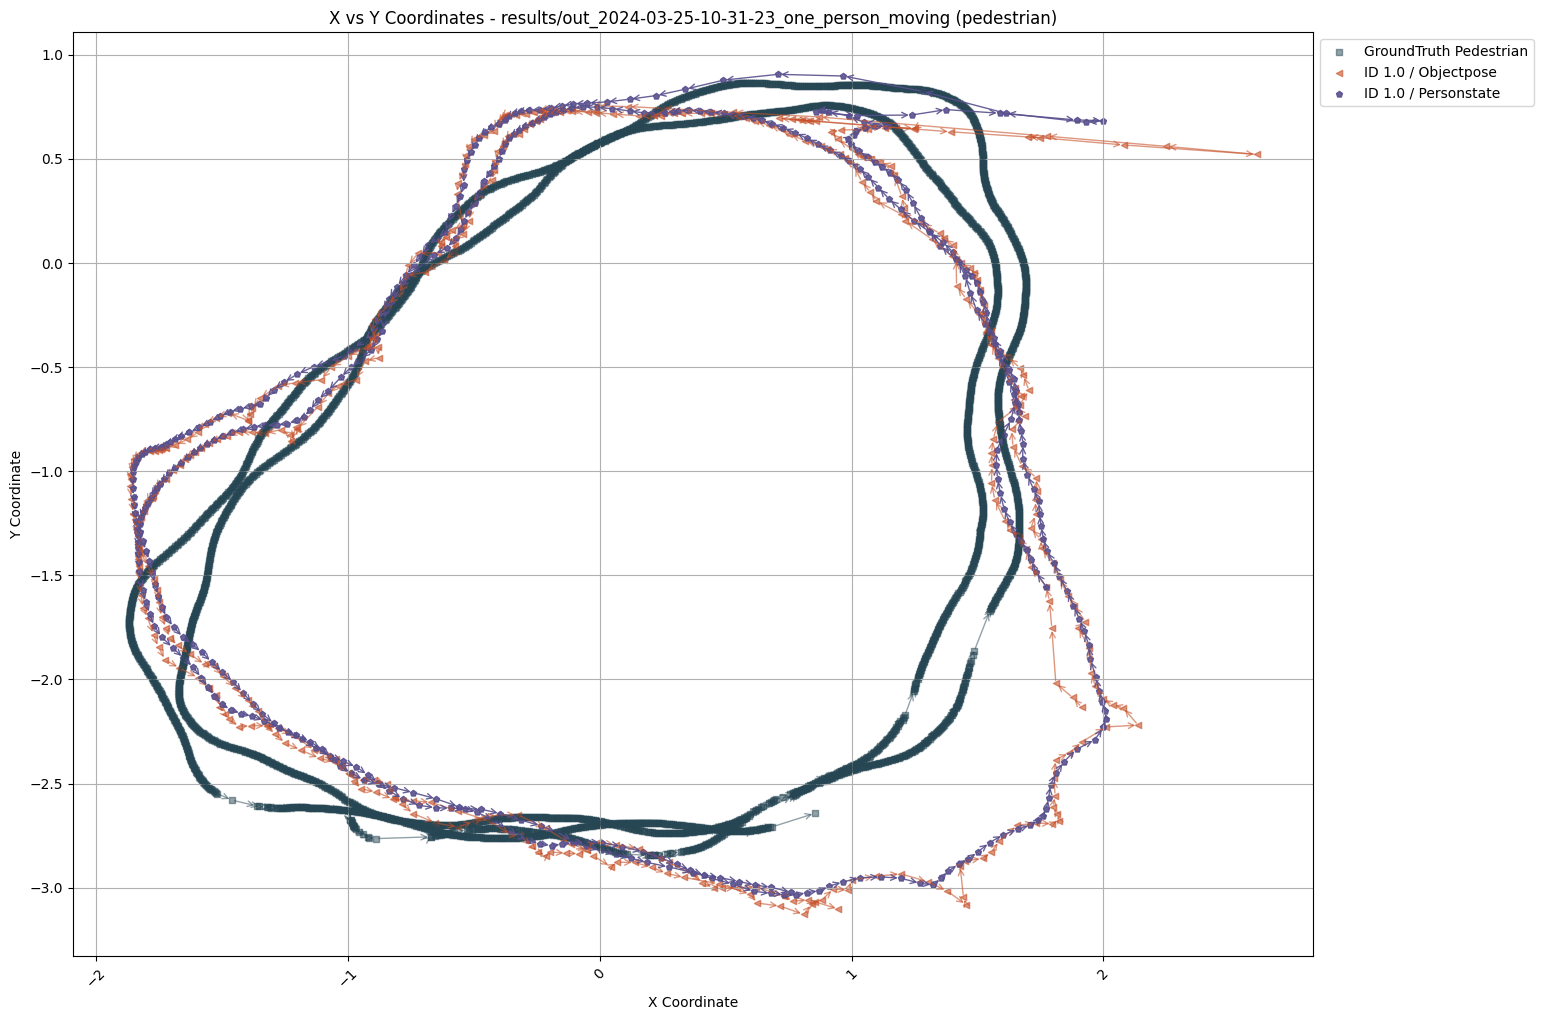

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


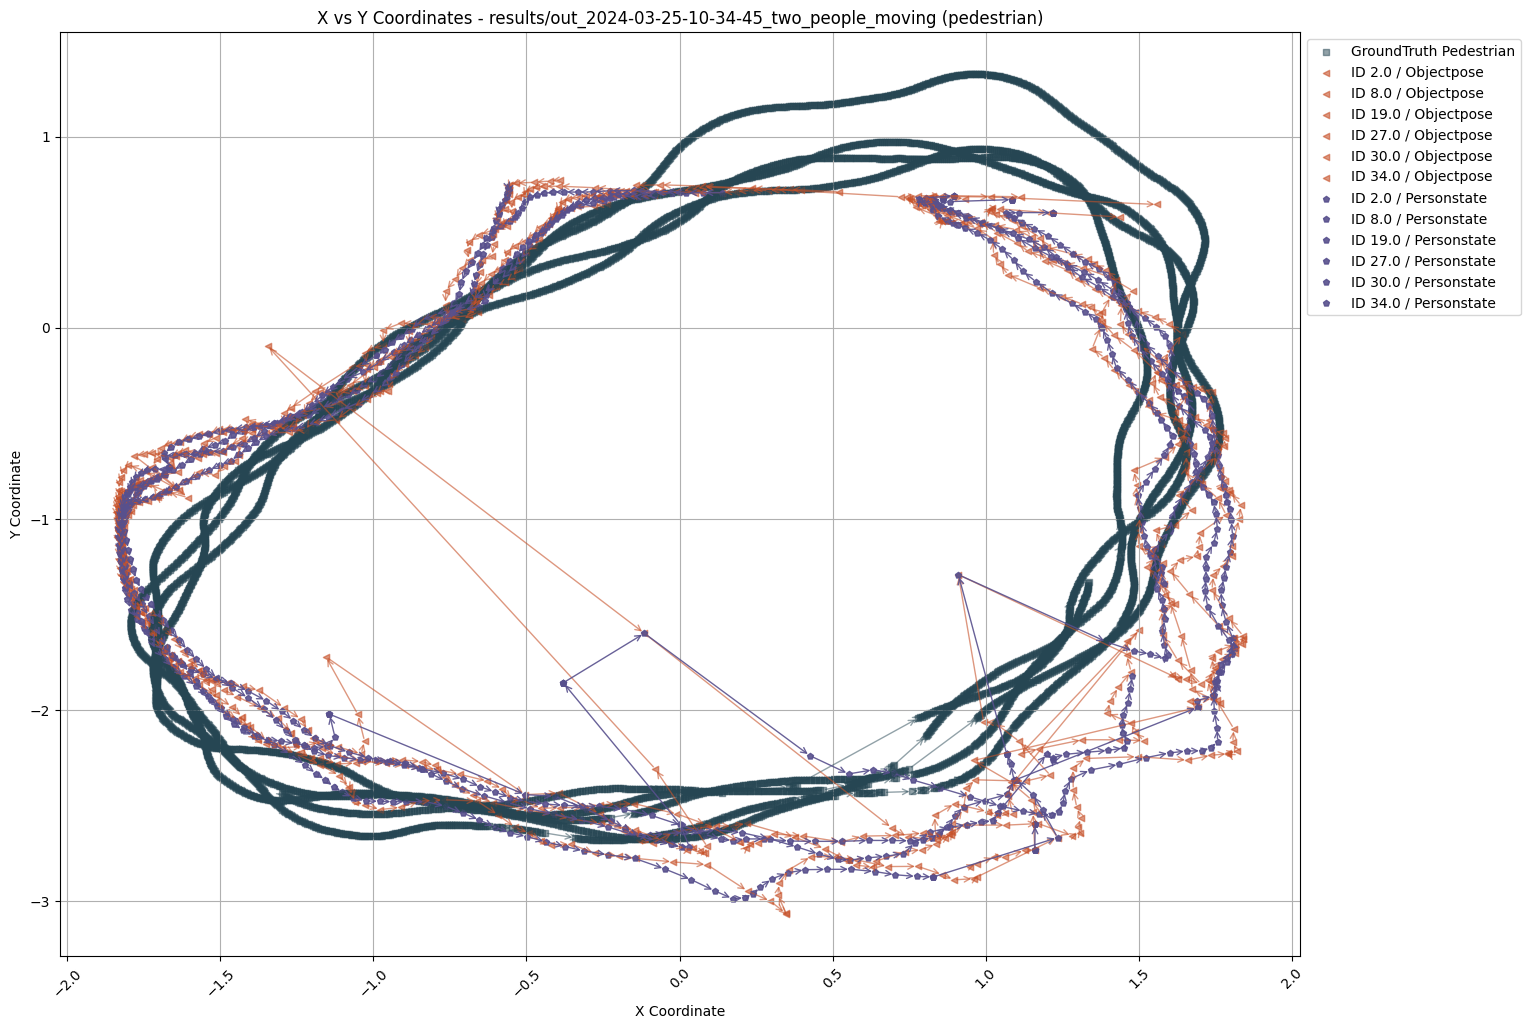

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


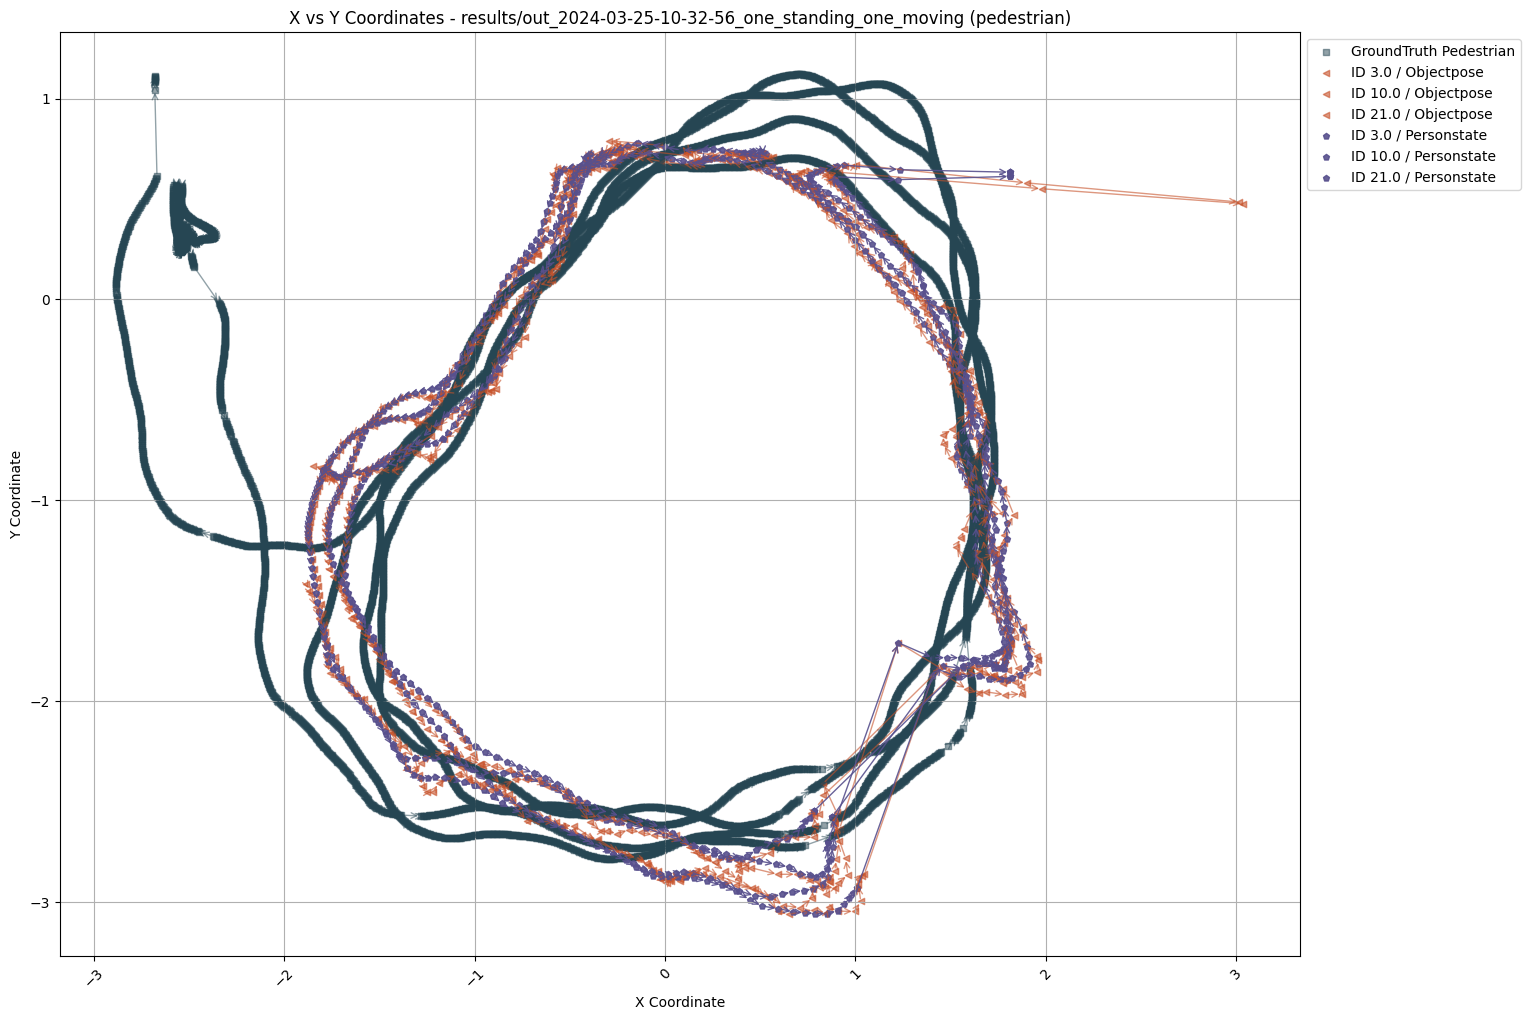

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


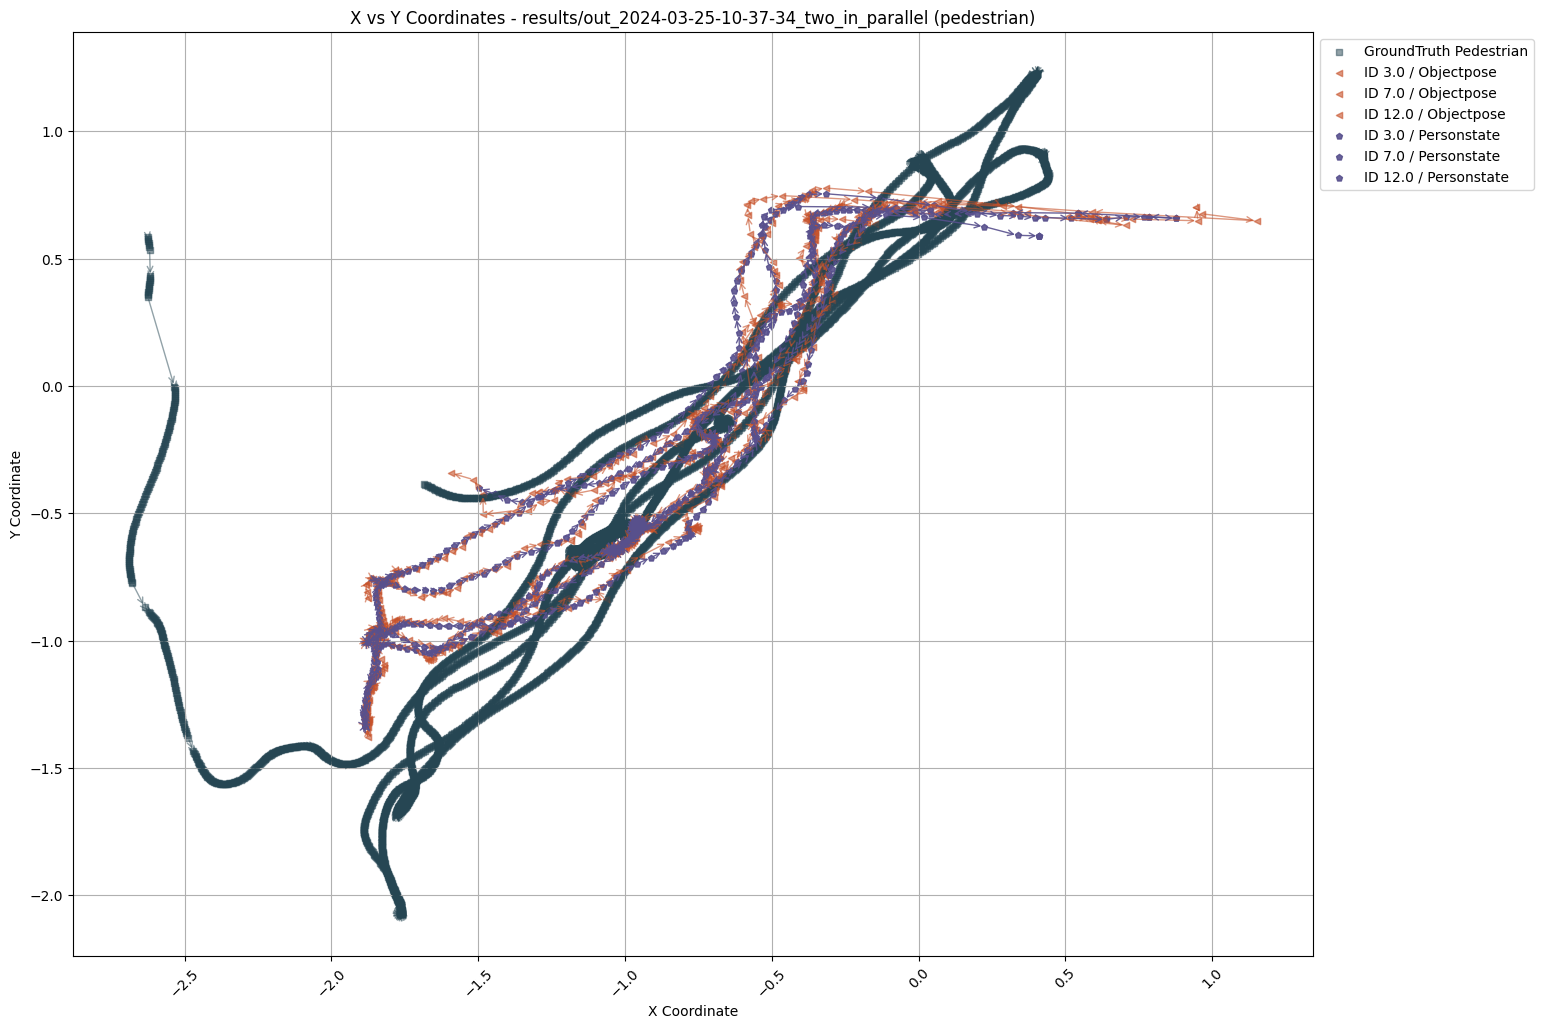

In [322]:
entity_to_plot = 'pedestrian'  # or 'tinman'

for file_path in data_paths:
    file_path = 'results/' + file_path
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Determine the IDs to plot based on the entity
    id_list = clasiffied_ids_all[os.path.basename(file_path)][0 if entity_to_plot == 'pedestrian' else 1]
    
    for i, topic in enumerate(topics):
        print('topic:', topic)
        if 'velocity' in topic or not os.path.isfile(file_path+topic): continue
        if ('pedestrian' in topic and entity_to_plot == 'tinman') or  ('tinman' in topic and entity_to_plot == 'pedestrian') : continue
        df = read_data(file_path, topic)
        person_id_col, x_coord, y_coord, topic_label, alpha = get_topic_data(topic)

        # Determine color for the topic
        color = COLORS[i % len(COLORS)]  # Cycle through a predefined COLORS list
        
        # Adjust function call to include entity IDs and color
        plot_topic_for_persons_direction(df, person_id_col, id_list, topic=topic_label, xaxis=x_coord, yaxis=y_coord, marker=MARKERS[i], ax=ax, alpha=alpha, color=color)

    ax.set_title(f"X vs Y Coordinates - {file_path} ({entity_to_plot})")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


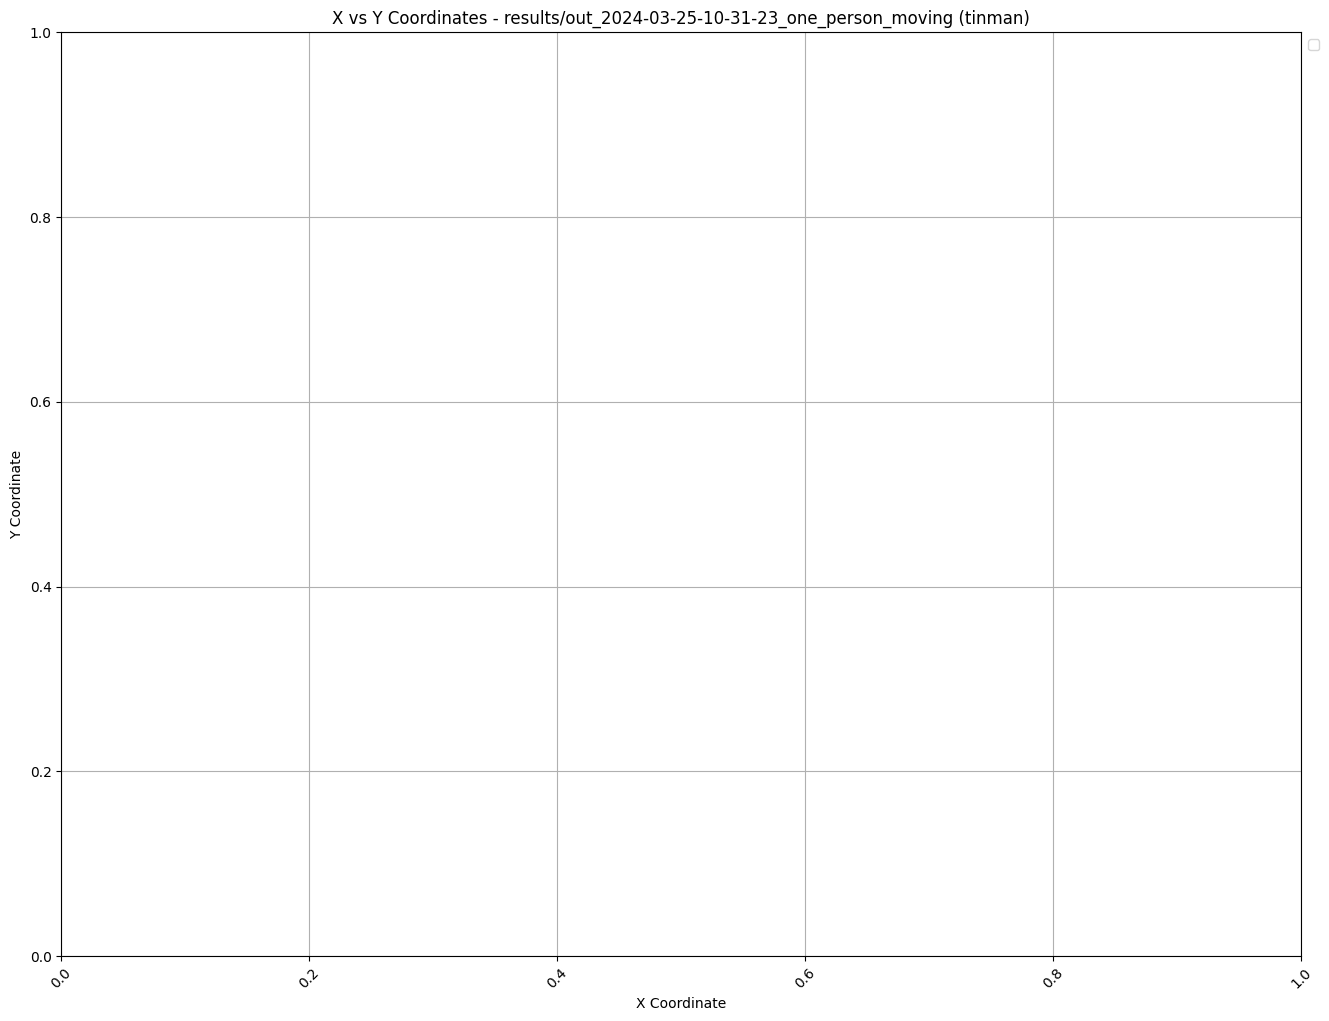

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


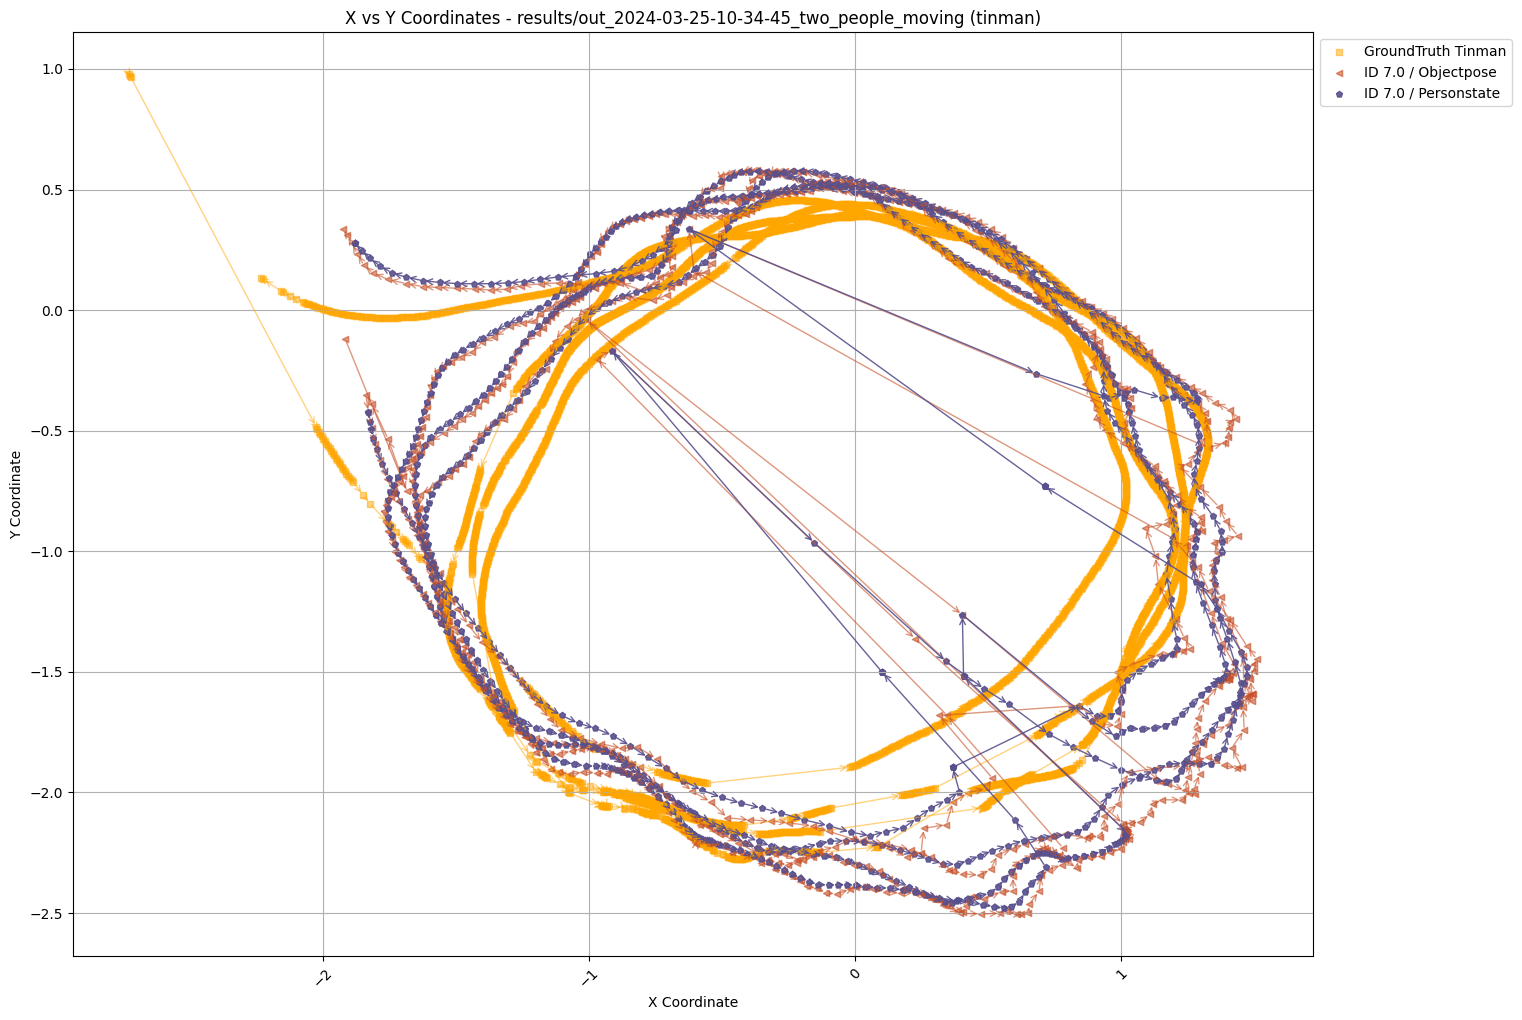

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


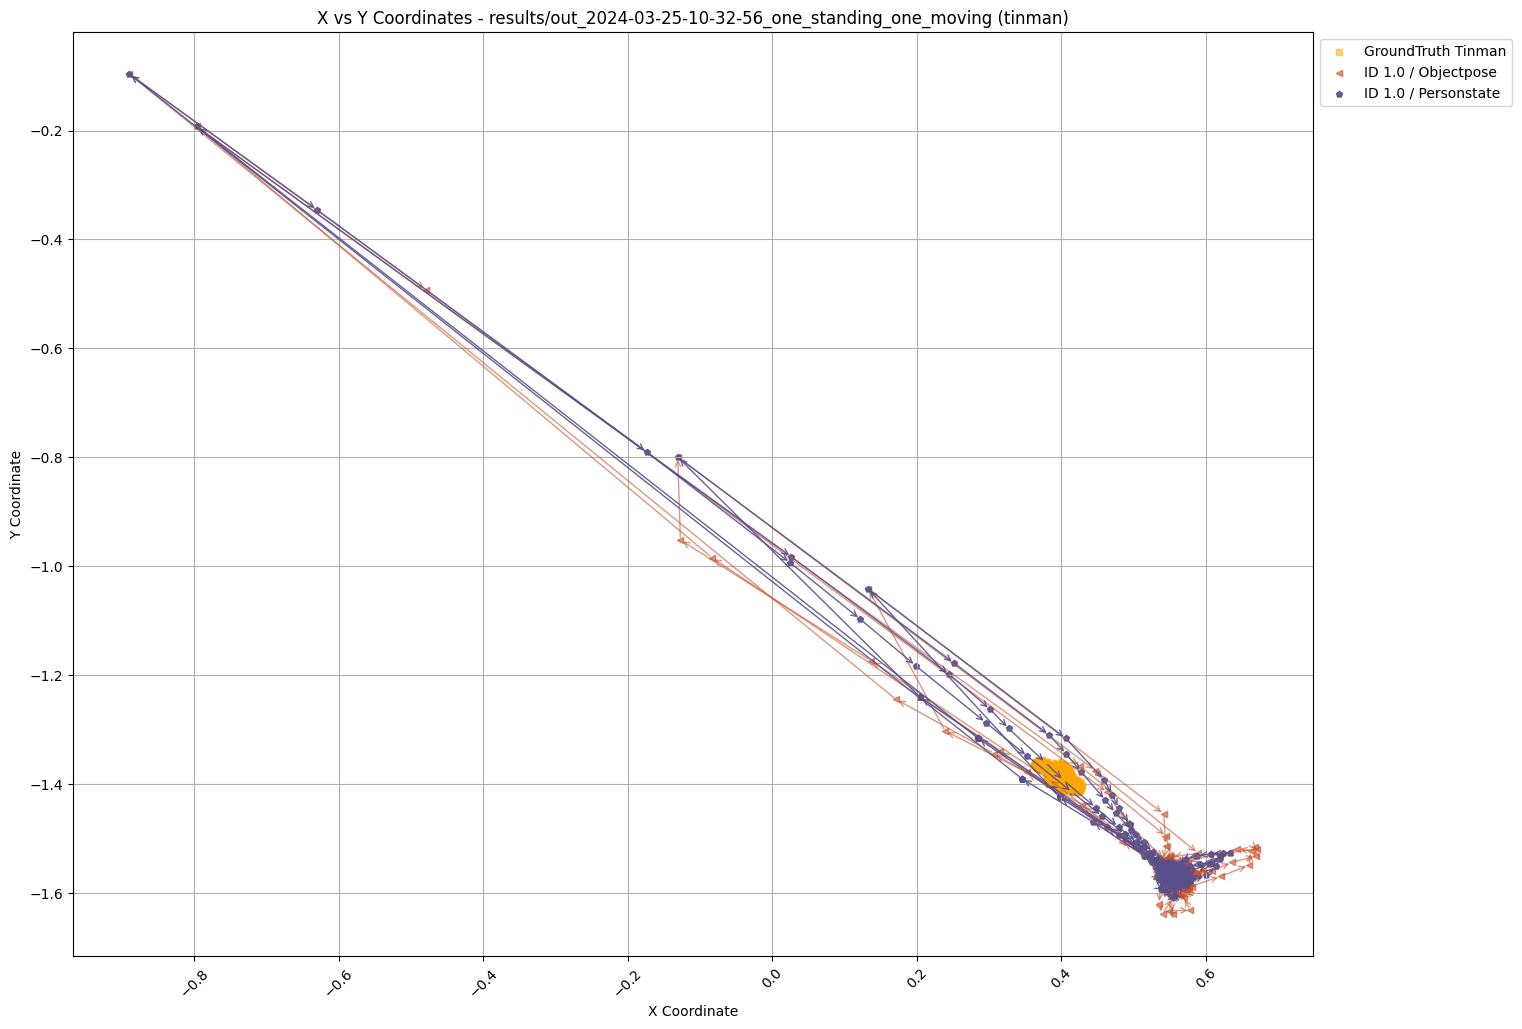

topic: /_qualisys_pedestrian_pose.csv
topic: /_qualisys_tinman_pose.csv
topic: /_qualisys_pedestrian_velocity.csv
topic: /_qualisys_tinman_velocity.csv
topic: /_objectposes.csv
topic: /_person_state_estimation_person_states.csv


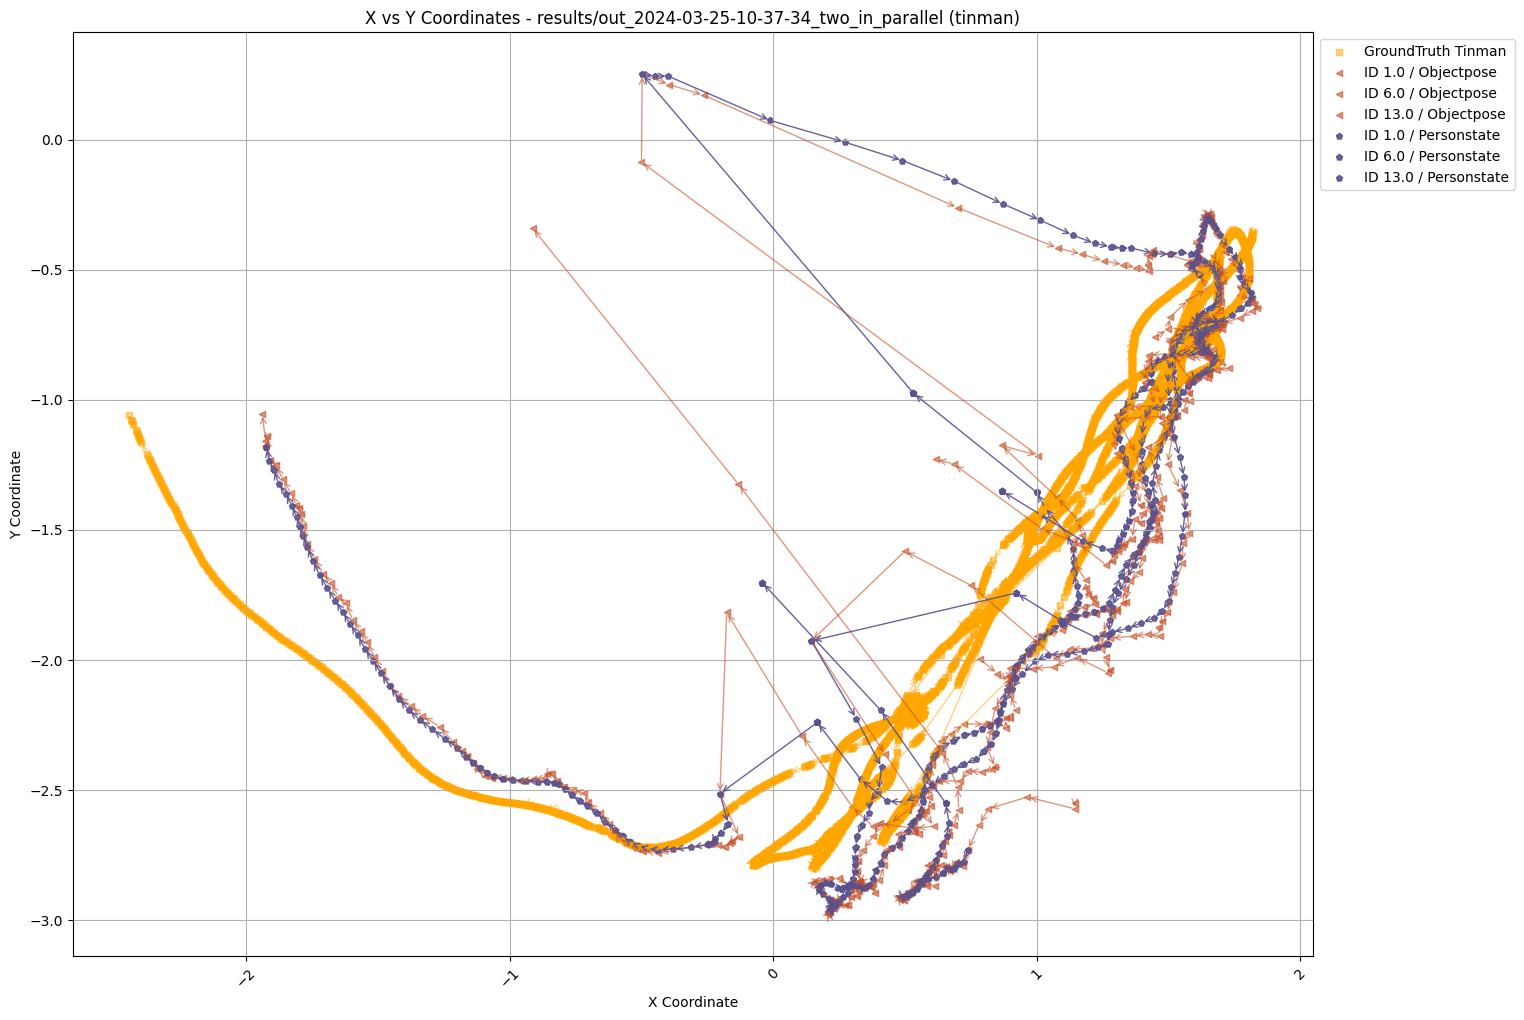

In [323]:
entity_to_plot = 'tinman'

for file_path in data_paths:
    file_path = 'results/' + file_path
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Determine the IDs to plot based on the entity
    id_list = clasiffied_ids_all[os.path.basename(file_path)][0 if entity_to_plot == 'pedestrian' else 1]
    
    for i, topic in enumerate(topics):
        print('topic:', topic)
        if 'velocity' in topic or not os.path.isfile(file_path+topic): continue
        if ('pedestrian' in topic and entity_to_plot == 'tinman') or  ('tinman' in topic and entity_to_plot == 'pedestrian') : continue
        df = read_data(file_path, topic)
        person_id_col, x_coord, y_coord, topic_label, alpha = get_topic_data(topic)

        # Determine color for the topic
        color = COLORS[i % len(COLORS)]  # Cycle through a predefined COLORS list
        
        # Adjust function call to include entity IDs and color
        plot_topic_for_persons_direction(df, person_id_col, id_list, topic=topic_label, xaxis=x_coord, yaxis=y_coord, marker=MARKERS[i], ax=ax, alpha=alpha, color=color)

    ax.set_title(f"X vs Y Coordinates - {file_path} ({entity_to_plot})")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()
